# Exploratory Data Analysis and Feature Extraction
***

# Installing Packages and Libraries

In [1]:
# Uncomment to upgrade packages
# %pip install pandas
# %pip install scipy
# %pip install numpy
# %pip install statsmodels
# %pip install seaborn
# %pip install ucimlrepo

In [2]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

In [3]:
# extra imports
from pandas import read_csv
from scipy.stats import boxcox, shapiro, chi2, chi2_contingency
from matplotlib import patches
import seaborn as sns

***
# Defining Functions

In [4]:
def print_categorical_variables(df):
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns
    print("Categorical Variables:")
    for var in categorical_vars:
        categories = df[var].unique()
        categories_str = [str(category) for category in categories]  # Convert to str
        print(f"{var}: {', '.join(categories_str)}")

def print_numerical_variables(df):
    numerical_vars = df.select_dtypes(exclude=['object', 'category']).columns
    print("Numerical Variables:")
    for var in numerical_vars:
        print(var)

def split_cat_num_columns(df):
    #Split for further analysis between categorical and numerical variables
    cat_cols = []
    num_cols = []

    for col in df.columns:
        if df[col].dtype in ['object', 'category']:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return cat_cols, num_cols

def plot_dataframe(df, x=4, y =4):
    
    cat_cols, _ = split_cat_num_columns(df)
    
    # Define custom color palette
    colors = ['#648E9C', '#9CB1BC', '#C5D4DE', '#E8F1F4']

    # Create figure and axes
    fig, axes = plt.subplots(x, y, figsize=(18, 16))

    # Set axis labels font properties
    font_props = {'fontsize': 10}

    # Plot each variable
    for i, col in enumerate(df.columns):
        ax = axes.reshape(-1)[i]
        if col in cat_cols:
            sns.countplot(x=col, data=df, ax=ax, palette=colors)
            ax.set_xlabel(col, fontdict=font_props)
            ax.set_ylabel('Count', fontdict=font_props)

            # Add numbers on top of the bars
            for p in ax.patches:
                ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=8)
        else:
            sns.histplot(x=col, data=df, ax=ax, color=colors[0], kde=True, stat="density")
            kde_color = '#9C648E'  # Desired color for the Gaussian curves
            sns.kdeplot(x=col, data=df, ax=ax, color=kde_color, lw=1.5)
            ax.set_xlabel(col, fontdict=font_props)
            ax.set_ylabel('Density', fontdict=font_props)

        # Rotate x-axis labels
        ax.tick_params(axis='x', labelrotation=45)
        ax.tick_params(axis='both', labelsize=8)

        # Adjust y-axis limit to leave space for the numbers
        ax.set_ylim(0, ax.get_ylim()[1] * 1.15)

    # Adjust spacing between subplots
    plt.tight_layout(pad=2.0)

    # Display the plot without the messages
    plt.show();
    
def calculate_outliers(data, column):
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    extreme_lower_bound = q1 - 3 *iqr
    upper_bound = q3 + 1.5 * iqr
    extreme_upper_bound = q3 + 3*iqr
    
    outliers = data[column][(data[column] < lower_bound) | (data[column] > upper_bound)]
    extreme_outliers = data[column][(data[column] < q1 - 3 * iqr) | (data[column] > q3 + 3 * iqr)]

    return q1, q3, iqr, lower_bound, upper_bound, extreme_lower_bound, extreme_upper_bound, outliers, extreme_outliers

def plot_boxplot_histogram(data, column):
    # Define custom color palette
    colors = ['#648E9C', '#9CB1BC', '#C5D4DE', '#E8F1F4']

    # Calculate outliers and extreme outliers
    q1, q3, iqr, lower_bound, upper_bound, extreme_lower_bound, extreme_upper_bound, outliers, extreme_outliers = calculate_outliers(data, column)

    # Create subplots with custom width ratios and figure size
    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))

    # Box plot
    boxplot = axes[0].boxplot(data[column], showfliers=True)
    axes[0].set_title(f'{column} - Box Plot', fontsize=12)
    axes[0].set_ylabel(f'{column}', fontsize=10)
    
    # Plot the boundary lines for outliers in the box plot if they exist
    if outliers.any():
        axes[0].axhline(lower_bound, color='#9C648E', linestyle='--')
        axes[0].axhline(upper_bound, color='#9C648E', linestyle='--')
    
    # Plot the boundary lines for extreme outliers in the box plot if they exist
    if extreme_outliers.any():
        axes[0].axhline(extreme_lower_bound, color='#3F51B5', linestyle='--')
        axes[0].axhline(extreme_upper_bound, color='#3F51B5', linestyle='--')

    # Change color of extreme outliers to blue
    for flier in boxplot['fliers']:
        flier.set(marker='o', color='#3F51B5', alpha=0.5)

    # Histogram
    hist = sns.histplot(data=data, x=column, ax=axes[1], color=colors[0])
    axes[1].set_title(f'{column} - Histogram', fontsize=12)
    axes[1].set_xlabel(f'{column}', fontsize=10)
    axes[1].set_ylabel('Frequency', fontsize=10)

    # Plot the boundary lines for outliers in the histogram if they exist
    if outliers.any():
        hist.axvline(lower_bound, color='#9C648E', linestyle='--')
        hist.axvline(upper_bound, color='#9C648E', linestyle='--')
    
    # Plot the boundary lines for extreme outliers in the histogram if they exist
    if extreme_outliers.any():
        hist.axvline(extreme_lower_bound, color='#3F51B5', linestyle='--')
        hist.axvline(extreme_upper_bound, color='#3F51B5', linestyle='--')

    # Create legend for the plot
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='#9C648E', linestyle='--', markersize=5, label='Outlier Boundary'),
        plt.Line2D([0], [0], marker='o', color='#3F51B5', linestyle='--', markersize=5, alpha=0.5, label='Extreme Outlier')
    ]
    axes[1].legend(handles=legend_elements, loc='upper right')

    # Adjust tick label font size for both subplots
    for ax in axes:
        ax.tick_params(axis='both', labelsize=8)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show();

def print_outlier_analysis(column, q1, q3, iqr, lower_bound, upper_bound, extreme_lower_bound, extreme_upper_bound, outliers, extreme_outliers):
    print("{} Outlier Analysis:".format(column))
    print("-----------------------------")
    print("First Quartile (Q1): {:.2f}".format(q1))
    print("Third Quartile (Q3): {:.2f}".format(q3))
    print("Interquartile Range (IQR): {:.2f}".format(iqr))
    print("Extreme Lower Bound: {:.2f}".format(extreme_lower_bound))
    print("Lower Bound: {:.2f}".format(lower_bound))
    print("Upper Bound: {:.2f}".format(upper_bound))
    print("Extreme Upper Bound: {:.2f}".format(extreme_upper_bound))
    print(f"Outliers Length: {len(outliers)}")
    print(f"Extreme Outliers Length: {len(extreme_outliers)}")
    
def bivariate_numerical_exploratory_analysis(df, target):
    plt.rcParams['font.size']= 10
    colors = ['#648E9C', '#9C648E']
    sns.pairplot(df, hue=target, palette=colors, plot_kws={'alpha': 0.75});

def plot_categorical_variables(data, target):
    categorical_vars = data.select_dtypes(include=['object', 'category']).columns

    num_plots = len(categorical_vars)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_plots - 1) // num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.flatten()
    for i, var in enumerate(categorical_vars):
        ax = sns.countplot(x=var, hue=target, data=data, ax=axes[i], palette=["#648E9C", "#9C648E"])
        axes[i].set_title(f'{var} vs {target}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Count')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].legend(title=target)

        # Calculate and display percentage values on top of each bar
        total_counts = len(data[var])
        for p in ax.patches:
            height = p.get_height()
            if (height / total_counts * 100) ==0:
                continue
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 3,
                    f'{height / total_counts * 100:.2f}%',
                    ha="center", fontsize='xx-small')

    # Hide empty subplots
    for j in range(i + 1, num_plots):
        fig.delaxes(axes[j])

    plt.tight_layout();
    plt.show();


def correlation_heatmap(df):
    numeric_cols = df.select_dtypes(include='number')  # Select only numeric columns
    correlation = numeric_cols.corr(method='spearman')
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    cmap = sns.color_palette(['#648E9C', '#9C648E'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation, annot=True, cmap=cmap, linewidths=0.5)
    plt.title('Correlation Matrix')
    # Rotate variable labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')
    plt.show();
    return correlation


def generate_cross_tabulations(df, target_var):
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns
    
    for var in categorical_vars:
        crosstab = pd.crosstab(df[var], df[target_var])
        row_sums = crosstab.sum(axis=0)
        col_sums = crosstab.sum(axis=1)
        
        print(f"Cross-tabulation for {var} and {target_var}:")
        print(crosstab)
        print("Row sums:")
        print(row_sums)
        print("Column sums:")
        print(col_sums)
        print("\n")

def perform_chi_squared_test(df, cat_cols):
    results = []
    
    for col1 in cat_cols:
        for col2 in cat_cols:
            if col1 != col2:
                contingency_table = pd.crosstab(df[col1], df[col2])
                chi2, p_value, _, _ = chi2_contingency(contingency_table)
                results.append((col1, col2, chi2, p_value))
    
    results_df = pd.DataFrame(results, columns=['Variable 1', 'Variable 2', 'Chi-square', 'P-value'])
    return results_df


***
# SECTION 1: Importing the Dataset `Bank Marketing` from UCI repository

In this first part we are going to load the dataset, explore it and get some first insights.

In [5]:
bank_marketing = pd.read_csv("../data/bank-full.csv", delimiter=';', quotechar='"')

In [6]:
bank_marketing.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

In [7]:
# bank_marketing = pd.concat([X, y], axis=1)
bank_marketing.shape

(45211, 17)

As we can see, the dataset has **45211** observations and **17** columns (variables). Our target value is the 17th (**y**), which is the `Subscription Status` of the client and it is binary (`yes` or `no`).

In [8]:
bank_marketing.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

Below we can see the first 5 rows of the dataset in order to have a brief overview of the available data.

In [9]:
bank_marketing.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

In [10]:
# Replace 'unknown' with NaN
bank_marketing.replace('unknown', pd.NA, inplace=True)

***
# SECTION 2: Basic Inspection of the Dataset

To begin with, a quick look at the variables types is taking place. 

In [11]:
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        44923 non-null  object
 2   marital    45211 non-null  object
 3   education  43354 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    32191 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   8252 non-null   object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [12]:
nan_count = bank_marketing.isna().sum()

print(nan_count)

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64


As it was mentioned in the dataset's metadata, there are in total **17** variables, **7** of which are `numerical` and **11** `categorical`. Also, as it can be seen in the results of the previous command that there are `null` values (**missing values**) included in the dataset, specifically for the variables: `job, education, contact, poutcome`.

Before proceeding with the treatment of the `missing values`, we need to take a look at the distribution of the numerical variables, as well as the categories of the categorical variables in order to fully understand the content of the variables and their categories, as well as the nature of their missing values.

In [13]:
bank_marketing.describe()

age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.000000  
max      871.000000    275.000000

The results here indicate that the `numerical variables` do not include any abnormally high maximums (e.g. 9999999), thus we can consider that the numerical variables luck of errors.

Some special cases are present only for the variables `balance` and `pdays`. It can be understood that the `min` value of `balance` being equal to **-8019** might refer to an erroneous case (will be analysed later). Additionally, for variable `pdays` the `min` value being equal to **-1** refers to cases, where the client was never been contacted before. Finally, from the statistics calculated one can understand that there are some outliers in some of the variables. For example in variable `duration`, the value **4918** (seconds) is extremely far from the rest of the distribution, meaning that the call of the marketing campaign call lasted around **82 minutes**. Outlier analysis is performed in the following sections.

Also, last contact duration (`duration`), which is counted in seconds, highly affects the **output target** (e.g., `if duration=0 then y='no'`). Yet, the duration is not known before a call is performed. Also, after the end of the call `y` is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. For that reason we proceed with removing the attribute `duration`.

In [14]:
# Filtering out rows where 'duration' is equal to 0
dur0 = bank_marketing[bank_marketing['duration'] == 0]

In [15]:
dur0.shape

(3, 17)

First of all, it can be seen that there are `3` cases where duration of a call is equal to 0. We though of first removing all observations that have duration equal to `0` and then drop the whole column.

In [16]:
bank_marketing = bank_marketing[bank_marketing['duration'] != 0]
bank_marketing.shape

(45208, 17)

In [17]:
bank_marketing.drop('duration', axis=1, inplace=True)
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45208 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45208 non-null  int64 
 1   job        44920 non-null  object
 2   marital    45208 non-null  object
 3   education  43351 non-null  object
 4   default    45208 non-null  object
 5   balance    45208 non-null  int64 
 6   housing    45208 non-null  object
 7   loan       45208 non-null  object
 8   contact    32189 non-null  object
 9   day        45208 non-null  int64 
 10  month      45208 non-null  object
 11  campaign   45208 non-null  int64 
 12  pdays      45208 non-null  int64 
 13  previous   45208 non-null  int64 
 14  poutcome   8252 non-null   object
 15  y          45208 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.9+ MB


As for the `categorical variables` by executing the following command, one can take a look at the available categories of the variables. 

In [18]:
print_categorical_variables(bank_marketing)

Categorical Variables:
job: management, technician, entrepreneur, blue-collar, <NA>, retired, admin., services, self-employed, unemployed, housemaid, student
marital: married, single, divorced
education: tertiary, secondary, <NA>, primary
default: no, yes
housing: yes, no
loan: no, yes
contact: <NA>, cellular, telephone
month: may, jun, jul, aug, oct, nov, dec, jan, feb, mar, apr, sep
poutcome: <NA>, failure, other, success
y: no, yes


From the result, it can be concluded that the categorical variables, contain some erroneous categories. For the categorical variables which include missing values (`job, education, contact, poutcome`), imputation techniques need to be considered. However, if the percentage of erroneous or missing data for a specific variable is large enough (e.g. 70%) then the best solution would be to not consider it part of the analysis.

Firstly, column `poutcome` will be dropped since the missing values exceed the **80%** of the dataset's number of rows. At the same time, variable `contact` is missing a total of **29%** of the dataset, thus imputing the missing values in this case might introduce bias. Thus, to deal with the missing values of `contact` column we will just replace `NA` values with a new category named `Unknown`. For the rest variables, imputation is performed in next sections.

In [19]:
bank_marketing = bank_marketing.drop('poutcome', axis=1)
nan_count = bank_marketing.isna().sum()
print(nan_count)

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13019
day              0
month            0
campaign         0
pdays            0
previous         0
y                0
dtype: int64


After dropping variables `duration, poutcome` we end up with **15** variables in total, **14** explanatory variables and a target one. **5** of the explanatory variables are `numerical`, **2** are `date` variables and **8** `categorical`. Finally, the target variable `y` is categorical as well.

With the following commands, we replace the missing values of the categorical variables, with a new category named `Unknown`. For `job` and `education` those `Unknown` cases will be imputed, as mentioned before.

In [20]:
# Fill remaining missing values with a default category (e.g., 'Unknown')
bank_marketing['job'].fillna('Unknown', inplace=True)
bank_marketing['education'].fillna('Unknown', inplace=True)
bank_marketing['contact'].fillna('Unknown', inplace=True)
nan_count = bank_marketing.isna().sum()
print(nan_count)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
y            0
dtype: int64


Finally, a brief description of the available variables is taking place:

**Numerical Variables**:
- **age**: Age of the client
- **balance**: Average yearly balance in euros
- **campaign**: Number of contacts performed during this campaign
- **pdays**: Number of days that passed by after the client was last contacted from a previous campaign
- **previous**: Number of contacts performed before this campaign

**Date Variables**:
- **day**: date variable representing the last contact day of the week
- **month**: date variable representing the last contact month of the year

   
**Categorical Variables**:
- **job**: Occupation type of the client. It can be *admin., blue-collar, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown*
- **marital**: Client’s marital status. It can be *divorced, married, single, unknown*. *Note*: divorced means *divorced* or *widowed*
- **education**: Refers to the the education level of the client. It can be *basic.4y, basic.6y, basic.9y, high school, illiterate, professional course, university degree, unknown*
- **default**: Refers to the fact that the client has credit or not in default
- **housing**: Describing whether the client has a housing loan 
- **loan**: Describing whether the client has a personal loan 
- **contact**: Representing the contact communication type. Categories: *cellular, telephone*
- **y**: target variable, binary, indicating whether the client has subscribed to a term deposit. It can be `yes` or `no`

Before moving to `Section 3`, it is important to mention that since the dataset contains observations of `three` years (May 2008 to November 2010), and we luck the information of the year of the `last contact`, it is impossible to combine `day` and `month` to find the real date of the last contact. This would be very usefull, in order to have the information if the call was done during the working days or the weekend..

***
# SECTION 3: Univariate Analysis

To begin with, we are deviding into two separate lists the column names of the `numerical` and `categorical` variables, respectively.

In [21]:
print_categorical_variables(bank_marketing)
print("\n")
print_numerical_variables(bank_marketing)

Categorical Variables:
job: management, technician, entrepreneur, blue-collar, Unknown, retired, admin., services, self-employed, unemployed, housemaid, student
marital: married, single, divorced
education: tertiary, secondary, Unknown, primary
default: no, yes
housing: yes, no
loan: no, yes
contact: Unknown, cellular, telephone
month: may, jun, jul, aug, oct, nov, dec, jan, feb, mar, apr, sep
y: no, yes


Numerical Variables:
age
balance
day
campaign
pdays
previous


Once the variables have been separated into `categorical` and `numerical`, it is possible to create a single plot containing all the `histograms` of the numerical variables and the `countplots` of the categorical variables. With the following visualisation, an initial overview of the distribution of the available variables is possible.

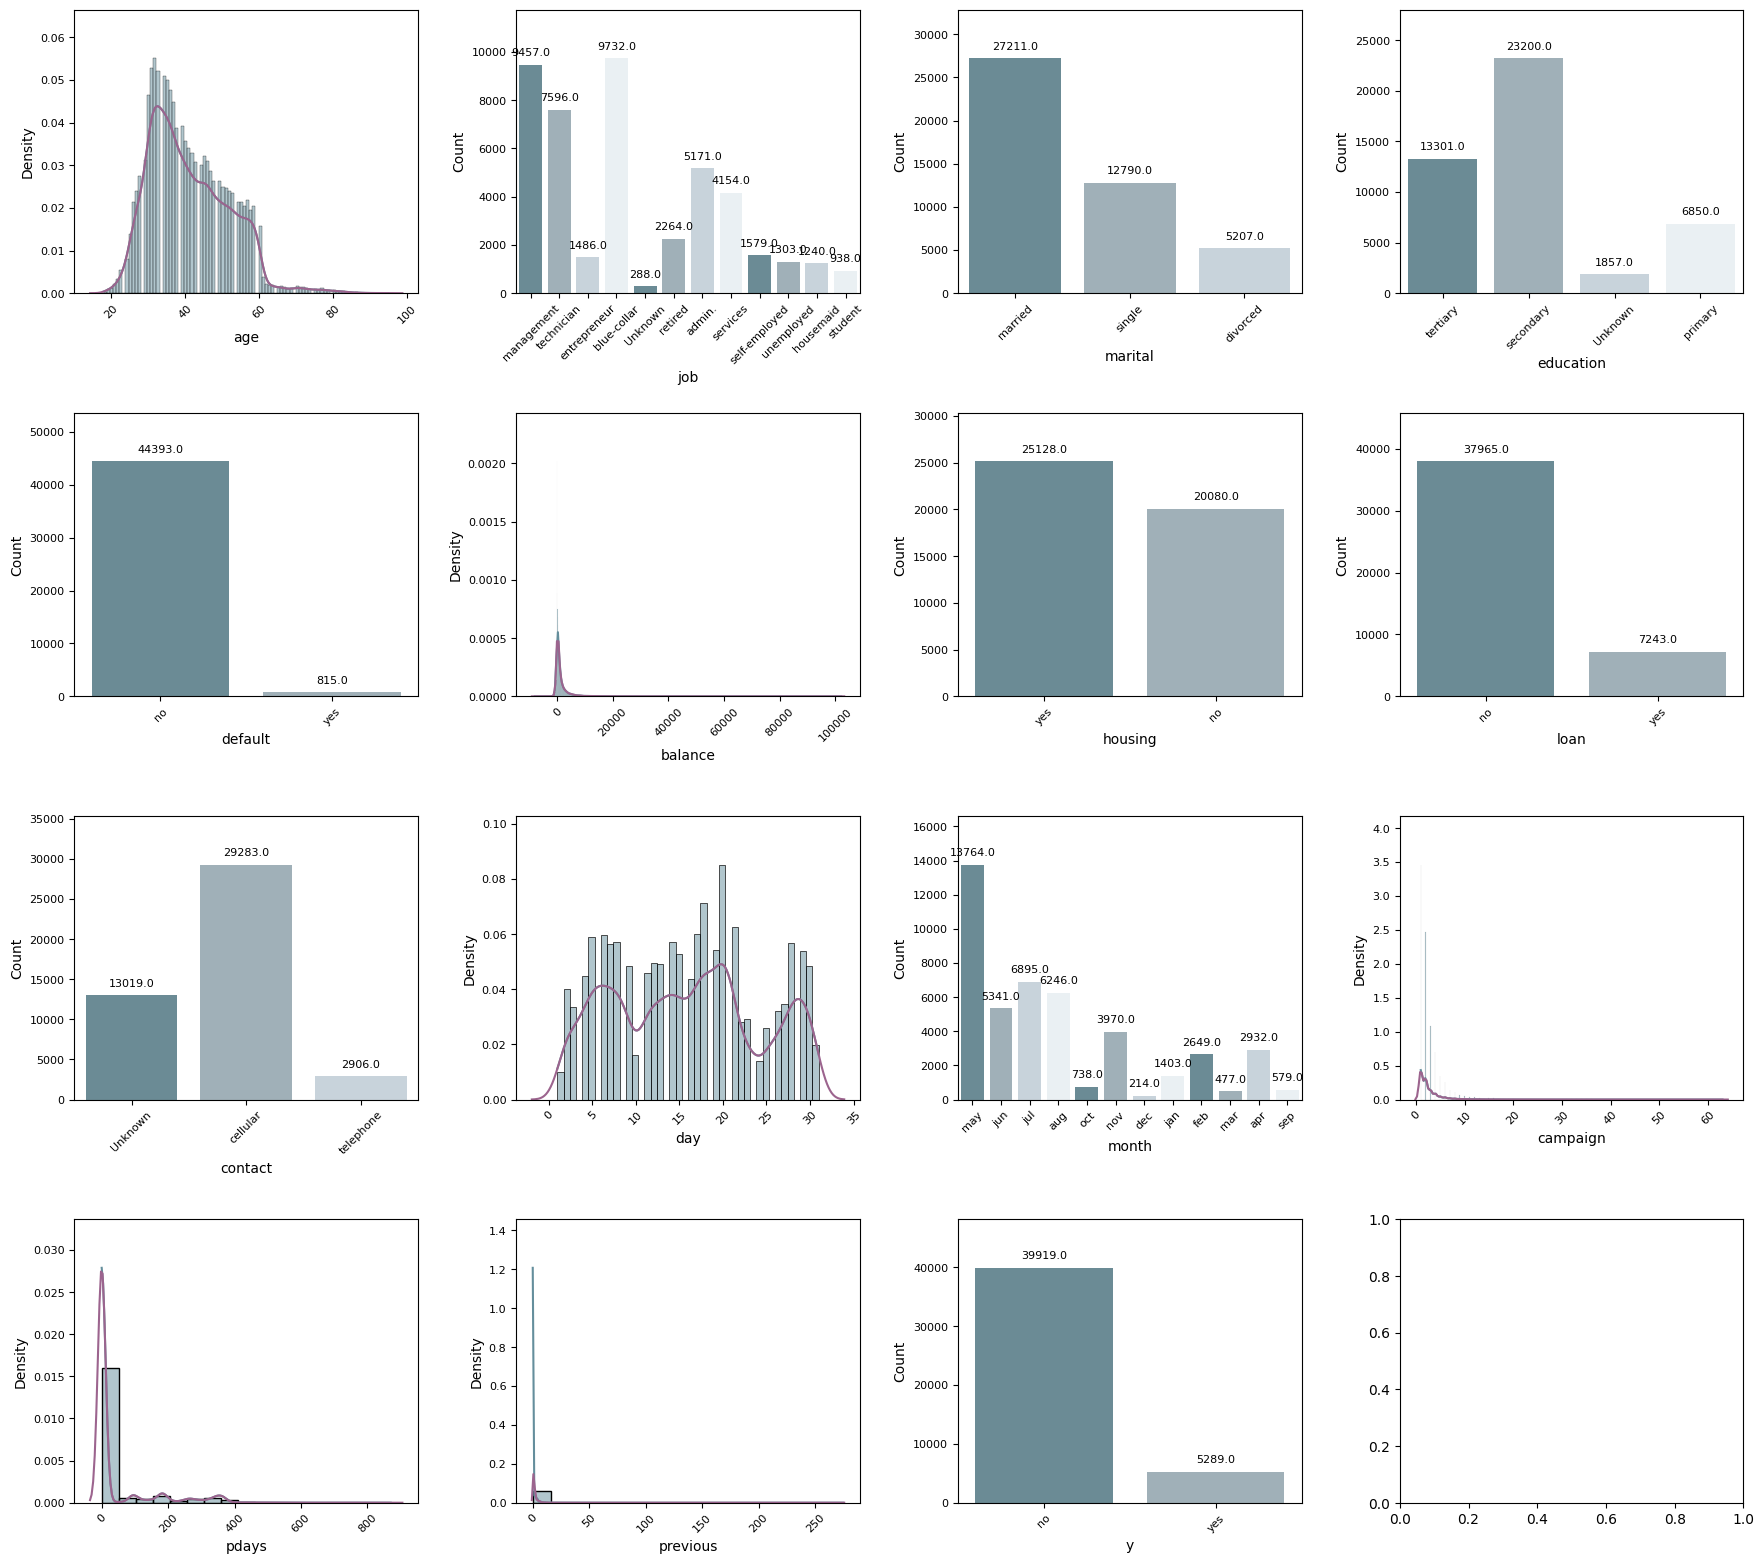

In [22]:
plot_dataframe(bank_marketing, 4, 4)

After analyzing the figures above, we can conclude that almost all of the variables have an unbalanced distribution. More speciffically:

Categorical Variables:
- `job`: The distribution of the client's jobs fluctuates from low values for specific job titles (**student, housemaid, student**), to very high ones for some others (**management, technician, blue-collar**).
- `marital`: Most of the clients in the dataset are `Married` and the difference between the groups is huge (**27211 married** compared to **12790 single** or **5207 divorced**).
- `education`: Most of the contacted clients have `secondary` education (**23200**), while the other education levels have considerably lower counts (**13301** for `tertiary`, **6850** for `primary`)
- `default`: **44393** clients do not have credit in default, compared to **815** that have 
- `housing`: Is quite balanced, with **25128** client's with housing loans, and **20080** without one.
- `loan`: Is unbalanced, with **37965** client's with personal loans, and **7243** without one.
- `contact`: The three categories are totally unbalanced, while the `telephone` one contains only **2906** observations, the `cellular` **29283**, and finally the `Unknown` (imputed) are **13019**.
- `month`: The `12` categories present high fluctuations. Most of the calls are being made between **May** and **August** compared to the rest of the year where the number of calls are way less.
- `y (Target Variable)`: The distribution is unbalacned for the target variable as well, since we obtain **39919** (~**89%**) observations for `no` cases and **5289** (~**11%**) for `yes`.

Numerical Variables:
- `age`: The distribution of age is quite fine, since there are several observation for mostly all the ages between **18** and **95** years old, although the mean value is around **40** years old.
- `balance`: The distribution of the clients' `average yearly balance in euros` is right-skewed, meaning that there are a lot of observations with small values, but at the same time there is a small number of observations with extrimely high values. This will lead to outliers and they need to be treated correctly.
- `day`: In this case the distribution is quite fine, presenting some autocorrelation, meaning that there are some repetitive patterns between week days, which makes sense. 
- `campaign`: It is right-skewed, thus observations with high values of `number of contacts performed during this campaign and for this client` need to be treated appropriately.
- `pdays`: Same is true for `pdays`. Observations with high values of `number of days that passed by after the client was last contacted from a previous campaign` need to be analysed more carefully.
- `previous`: The same happens for variable `previous`. Observations with high values of `number of contacts performed before this campaign and for this client`need to be taken into careful consideration.

The comments mentioned here need to be addressed in order to avoid fitting a learning algorithm described by high bias. For this reason, below the `Outliers Analysis` is included.

Before moving on to the `Outliers Analysis`, `Sharipo-normality` test is performed on the numerical values. In that way it can be statistically proven which numerical variables follow a normal distribution. Later in the `Bivariate Exploratory Analysis`, `Chi-Squared` tests are performed on the categorical variables as well, in order to check correlation between them.

## Shapiro Normality Tests & Boxcox Transformations

In [23]:
cat_cols, num_cols = split_cat_num_columns(bank_marketing)
#Check the normality
shapiro_results = []
for column in num_cols:
    stat, p_value = shapiro(bank_marketing[column])
    shapiro_results.append((column, stat, p_value))

shapiro_df = pd.DataFrame(shapiro_results, columns=['Variable', 'Statistic', 'P_Value'])
print(shapiro_df)

   Variable  Statistic  P_Value
0       age   0.960538      0.0
1   balance   0.457145      0.0
2       day   0.959487      0.0
3  campaign   0.550681      0.0
4     pdays   0.474810      0.0
5  previous   0.235600      0.0


The results of the Shapiro-Wilk normality test reveal that **none of the numerical variables** (age, balance, day_of_week, campaign, pdays and previous) **exhibit a normal distribution**, as `indicated by the zero p-values` obtained. This suggests that these variables deviate significantly from a normal distribution. To mitigate potential issues during the modeling phase, it is considered to apply suitable transformations or utilizing non-parametric models that do not rely on normality assumptions.

However, taking into account our numerical variables and by looking at the generated figures, it looks like `balance` could be transformed into a normal distribution with the usage of logarithmic transformation or the boxcox function. Here are the results:

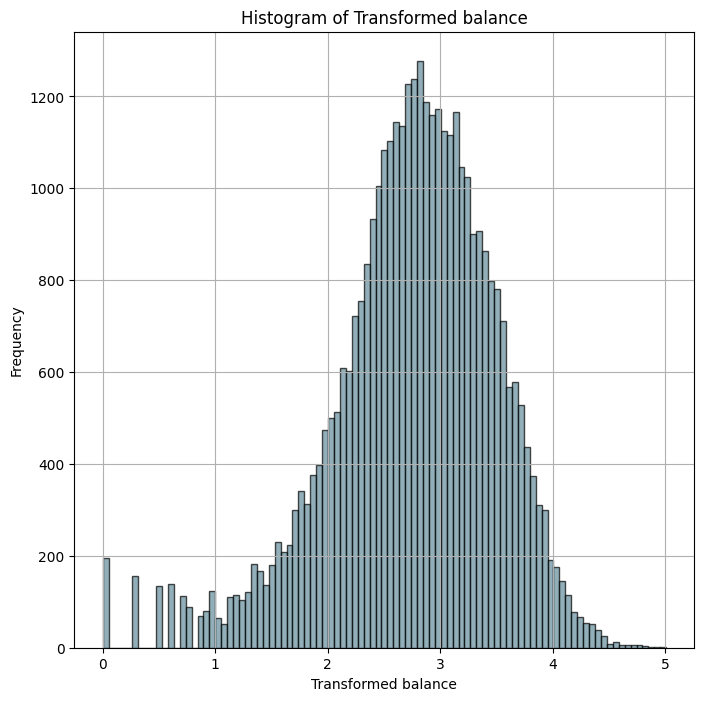

In [24]:
# Filter the DataFrame to exclude zero and negative values in 'duration'
filtered_balance = bank_marketing['balance'][bank_marketing['balance'] > 0]

# Apply log transformation to the filtered column
log_balance = filtered_balance.apply(np.log10)

# Plot the histogram of log-transformed values
log_balance.hist(bins='auto', figsize=(8, 8), color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed balance')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed balance');

When the positive values of the `balance` feature are transformed using the logarithmic function, they `tend to follow a normal distribution`. This result can come in handy when we are dealing with modeling of the data. Let's check the same for variables `campaing, pdays and previous`.

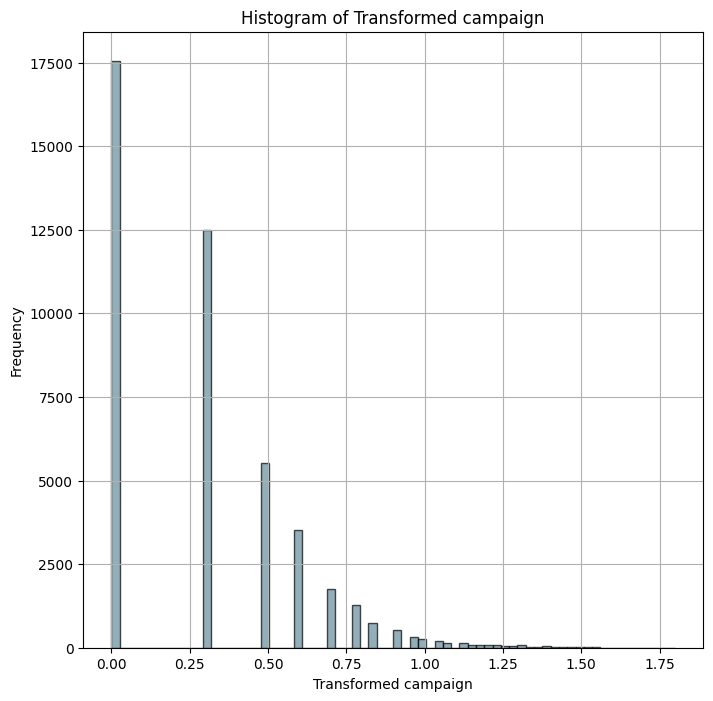

In [25]:
# Filter the DataFrame to exclude zero and negative values in 'campaign'
filtered_campaign = bank_marketing['campaign'][bank_marketing['campaign'] > 0]

# Apply log transformation to the filtered column
log_campaign = filtered_campaign.apply(np.log10)

# Plot the histogram of log-transformed values for 'campaign'
plt.figure(figsize=(8, 8))
log_campaign.hist(bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed campaign')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed campaign')
plt.show();

From the previous histogram, it can be derived that the `logarithm of variable campaign seems to follow a power-law distribution`.

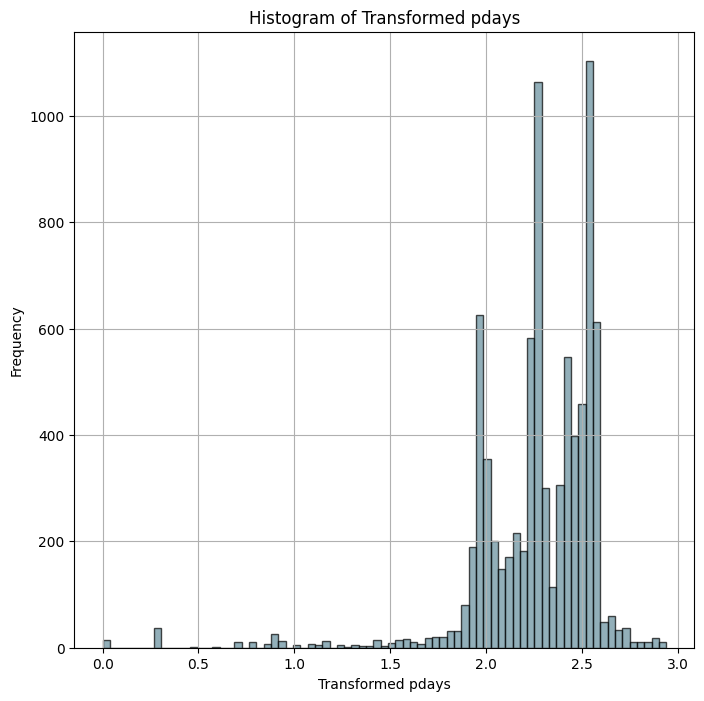

In [26]:
# Filter the DataFrame to exclude zero and negative values in 'pdays'
filtered_pdays = bank_marketing['pdays'][bank_marketing['pdays'] > 0]

# Apply log transformation to the filtered column
log_pdays = filtered_pdays.apply(np.log10)

# Plot the histogram of log-transformed values for 'pdays'
plt.figure(figsize=(8, 8))
log_pdays.hist(bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed pdays')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed pdays')
plt.show();

logarithmic version of `pdays` could be described maybe from the mixture of 3 separte gaussians (by looking at the 3 picks of the histogram) 

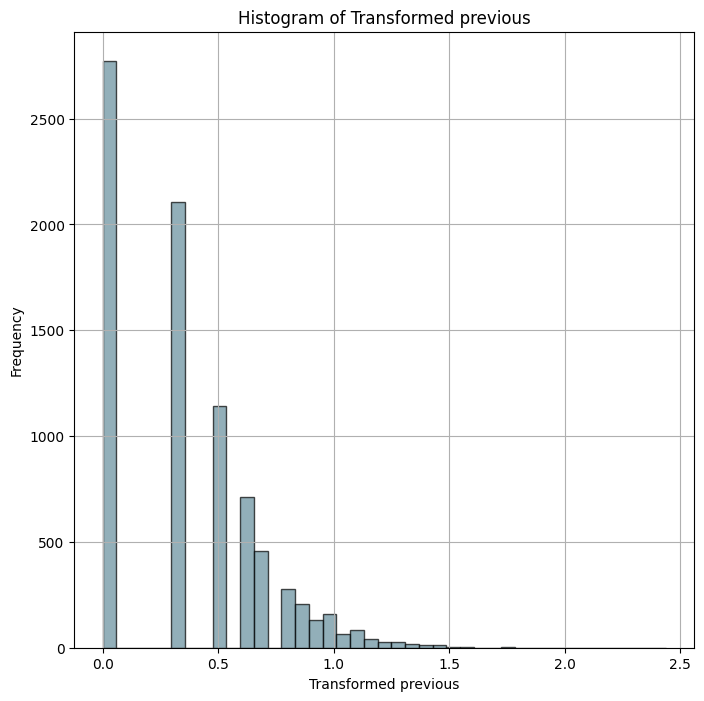

In [27]:
# Filter the DataFrame to exclude zero and negative values in 'previous'
filtered_previous = bank_marketing['previous'][bank_marketing['previous'] > 0]

# Apply log transformation to the filtered column
log_previous = filtered_previous.apply(np.log10)

# Plot the histogram of log-transformed values for 'previous'
plt.figure(figsize=(8, 8))
log_previous.hist(bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed previous')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed previous')
plt.show();

From the previous histogram, it can also be derived that the `logarithm of variable previous seems to follow a power-law distribution`.

Let's see the results provided from `boxcox` as well.

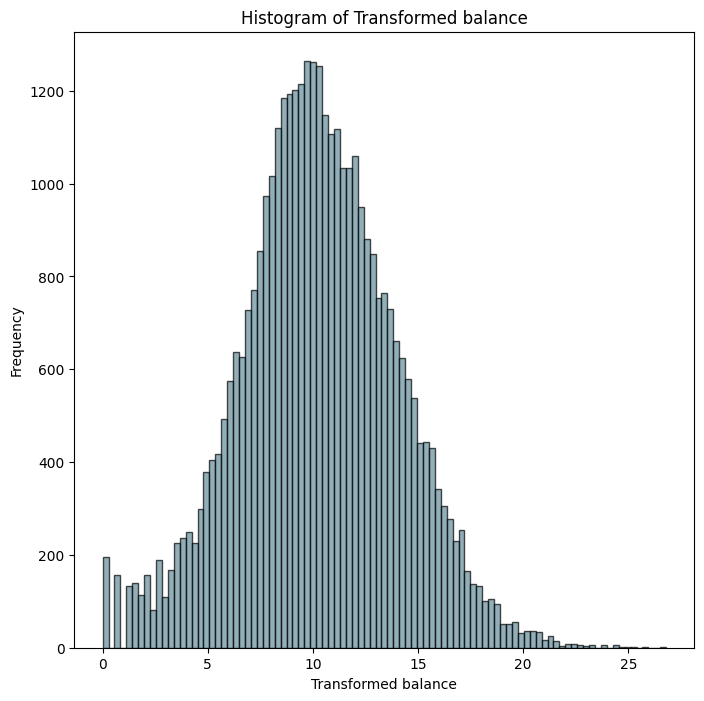

In [28]:
# Apply Box-Cox transformation to 'balance'
transformed_balance, lambda_balance = boxcox(filtered_balance)

# Create a new figure with the desired size
plt.figure(figsize=(8, 8))

# Plot the histogram of transformed 'balance'
plt.hist(transformed_balance, bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed balance')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed balance')
plt.show();

In [29]:
lambda_balance

0.13019340115134853

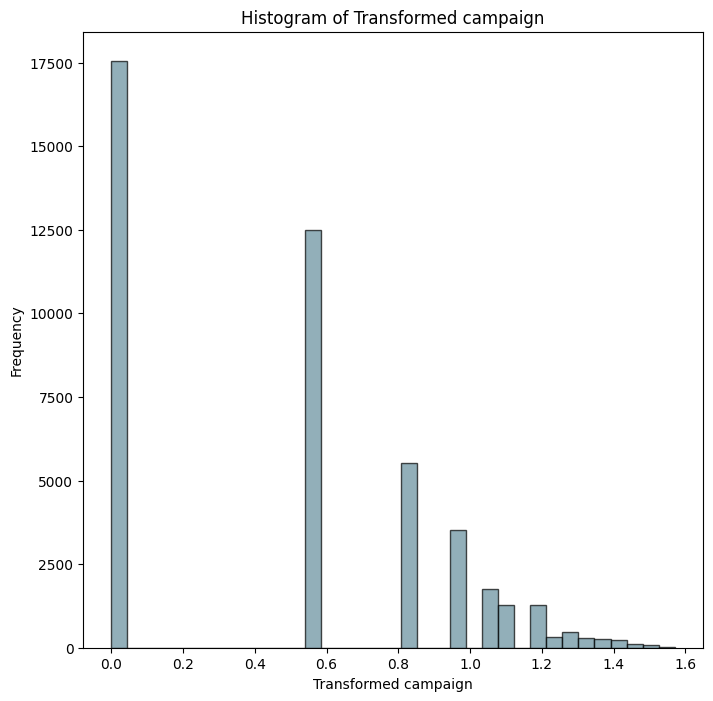

In [30]:
# Apply Box-Cox transformation to 'campaign'
transformed_campaign, lambda_campaign = boxcox(filtered_campaign)

# Create a new figure with the desired size
plt.figure(figsize=(8, 8))

# Plot the histogram of transformed 'campaign'
plt.hist(transformed_campaign, bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed campaign')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed campaign')
plt.show();

In [31]:
lambda_campaign

-0.5785395837793754

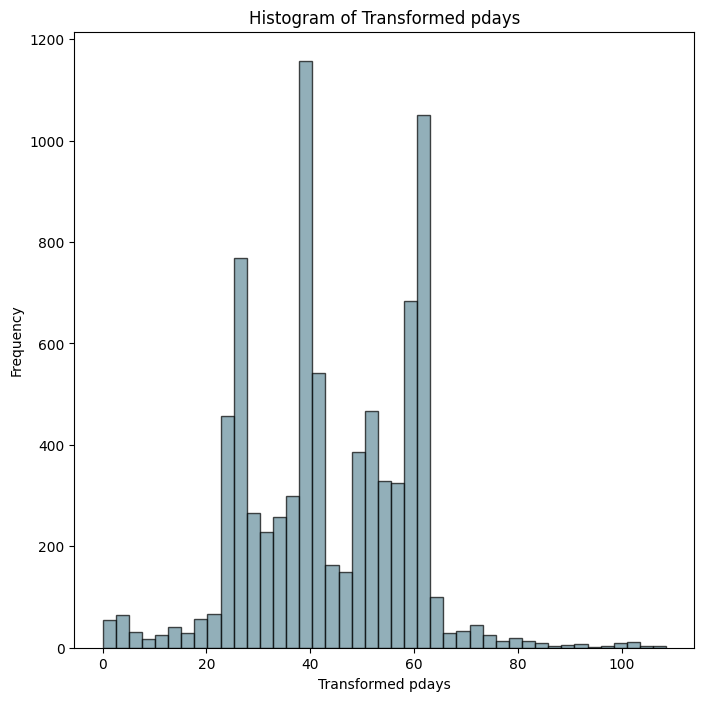

In [32]:
# Apply Box-Cox transformation to 'pdays'
transformed_pdays, lambda_pdays = boxcox(filtered_pdays)

# Create a new figure with the desired size
plt.figure(figsize=(8, 8))

# Plot the histogram of transformed 'pdays'
plt.hist(transformed_pdays, bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed pdays')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed pdays')
plt.show();

In [33]:
lambda_pdays

0.6250882055145279

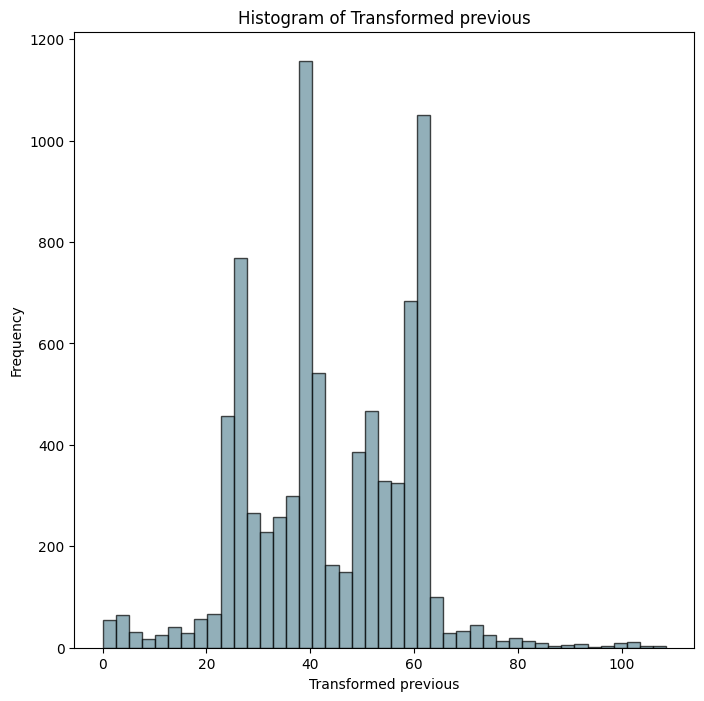

In [34]:
# Apply Box-Cox transformation to 'previous'
transformed_previous, lambda_previous = boxcox(filtered_previous)

# Create a new figure with the desired size
plt.figure(figsize=(8, 8))

# Plot the histogram of transformed 'previous'
plt.hist(transformed_pdays, bins='auto', color='#648E9C', alpha=0.7, edgecolor='black')
plt.xlabel('Transformed previous')
plt.ylabel('Frequency')
plt.title('Histogram of Transformed previous')
plt.show();

In [35]:
lambda_previous

-0.42721501114767646

Since the `lambda` variable is equal to `0.13` for variable `balance` it means that the transformation needed to be applied is the logarithmic (as previously shown). Also, for the variables `previous` and `campaing`, it could be usefull to take into consideration the power-law nature of their logarithmic transformation. 

Moreover, the outliers analysis and the extraction of new features will take place before we move on to preprocessing and normalizing the dataset. This decision is taken in order to check the correctness of the data, but in order to devide the preprocessing and normalization of the training and test data. In that way, we can be sure about the results of the model on the test data that would indicate if the model is able to generalize well or not, in new unseen cases. 

## Univariate Outliers Analysis

During the development and training of learning algorithms the inclusion of outliers can result in highly biased results, thus it is very important to treat them carefully, firstly, by identifying them and finally by imputing, removing, or just acknowledging their existence. The analysis is completed for all the numerical variables of the dataset. Firstly, `age` variable is being analyzed.

In [36]:
plot_boxplot_histogram(bank_marketing, 'age')

In [37]:
age_q1, age_q3, age_iqr, age_lower_bound, age_upper_bound, age_extreme_lower_bound, age_extreme_upper_bound, age_outliers, age_extreme_outliers = calculate_outliers(bank_marketing, 'age')
print_outlier_analysis('age', age_q1, age_q3, age_iqr, age_lower_bound, age_upper_bound, age_extreme_lower_bound, age_extreme_upper_bound, age_outliers, age_extreme_outliers)


age Outlier Analysis:
-----------------------------
First Quartile (Q1): 33.00
Third Quartile (Q3): 48.00
Interquartile Range (IQR): 15.00
Extreme Lower Bound: -12.00
Lower Bound: 10.50
Upper Bound: 70.50
Extreme Upper Bound: 93.00
Outliers Length: 487
Extreme Outliers Length: 3


Based on the `IQR` analyses, the methodology followed below is to discard `extreme outliers`. However, before doing so, a manual inspection is taking place for each variable, just to be sure that important information is not discarded.

In [38]:
bank_marketing.loc[age_extreme_outliers.index]

age      job   marital  education default  balance housing loan  \
31233   94  retired  divorced  secondary      no     1234      no   no   
33699   95  retired  divorced    primary      no     2282      no   no   
41663   95  retired   married  secondary      no        0      no   no   

         contact  day month  campaign  pdays  previous    y  
31233   cellular    3   mar         1     -1         0   no  
33699  telephone   21   apr        17     -1         0  yes  
41663  telephone    1   oct         1     -1         0   no

In [39]:
bank_marketing.shape

(45208, 15)

E.g. for variable `age` it can be seen that 3 `extreme outliers` occur, however they refer to elderly people, that can be retained in the analysis since they will not include bias to the model. Let's check the outliers for variable `balance`.

In [40]:
plot_boxplot_histogram(bank_marketing, 'balance')

In [41]:
bln_q1, bln_q3, bln_iqr, bln_lower_bound, bln_upper_bound, bln_extreme_lower_bound, bln_extreme_upper_bound, bln_outliers, bln_extreme_outliers = calculate_outliers(bank_marketing, 'balance')
print_outlier_analysis('balance', bln_q1, bln_q3, bln_iqr, bln_lower_bound, bln_upper_bound, bln_extreme_lower_bound, bln_extreme_upper_bound, bln_outliers, bln_extreme_outliers)

balance Outlier Analysis:
-----------------------------
First Quartile (Q1): 72.00
Third Quartile (Q3): 1428.00
Interquartile Range (IQR): 1356.00
Extreme Lower Bound: -3996.00
Lower Bound: -1962.00
Upper Bound: 3462.00
Extreme Upper Bound: 5496.00
Outliers Length: 4728
Extreme Outliers Length: 2442


So here for the variable `balance` we can see that there are **4728** outliers in total (starting from values of **3462.00** for the upper bound and **-1962.00** for the lower bound), from which **2442** are considered extreme outliers. By taking a look at the observations of extreme outlliers for `balance`, we consider of retaining all observations. Additionaly analysis about those cases will be completed during the modelling part of the project. More specifically:

In [42]:
bank_marketing['balance'].describe()

count     45208.000000
mean       1362.228676
std        3044.794660
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [43]:
bln_outliers.describe()

count      4728.000000
mean       7540.167301
std        6318.339179
min       -8019.000000
25%        4323.000000
50%        5609.000000
75%        8266.000000
max      102127.000000
Name: balance, dtype: float64

In [44]:
bln_extreme_outliers.describe()

count      2442.000000
mean      10570.157248
std        7597.967513
min       -8019.000000
25%        6530.250000
50%        8137.000000
75%       11627.750000
max      102127.000000
Name: balance, dtype: float64

In [45]:
bank_marketing.loc[bln_extreme_outliers.index]

age          job  marital  education default  balance housing loan  \
34      51   management  married   tertiary      no    10635     yes   no   
65      51   management  married   tertiary      no     6530     yes   no   
69      35  blue-collar   single  secondary      no    12223     yes  yes   
70      57  blue-collar  married  secondary      no     5935     yes  yes   
205     50     services  married  secondary      no     5699     yes   no   
...    ...          ...      ...        ...     ...      ...     ...  ...   
45110   50   management  married   tertiary      no     8205     yes   no   
45118   78      retired  married    primary      no    14204      no   no   
45127   67  blue-collar  married  secondary      no    16353      no   no   
45181   46  blue-collar  married  secondary      no     6879      no   no   
45208   72      retired  married  secondary      no     5715      no   no   

         contact  day month  campaign  pdays  previous    y  
34       Unknown    5   may         1     -1         0   no  
65       Unknown    5   may         1     -1         0   no  
69       Unknown    5   may         1     -1         0   no  
70       Unknown    5   may         1     -1         0   no  
205      Unknown    5   may         2     -1         0   no  
...          ...  ...   ...       ...    ...       ...  ...  
45110  telephone   25   oct         3    508         1   no  
45118   cellular   26   oct         1    183         1   no  
45127   cellular   27   oct         2     -1         0   no  
45181   cellular   15   nov         2    118         3   no  
45208   cellular   17   nov         5    184         3  yes  

[2442 rows x 15 columns]

The following command is performed, just to have a look at client's with negative balance.

In [46]:
bank_marketing[bank_marketing['balance'] < 0]

age          job   marital  education default  balance housing loan  \
25      44       admin.   married  secondary      no     -372     yes   no   
28      46   management    single  secondary      no     -246     yes   no   
36      25  blue-collar   married  secondary      no       -7     yes   no   
37      53   technician   married  secondary      no       -3      no   no   
45      36       admin.    single    primary      no     -171     yes   no   
...    ...          ...       ...        ...     ...      ...     ...  ...   
44626   31     services    single  secondary      no     -205      no   no   
44629   28  blue-collar    single  secondary      no      -46     yes   no   
44836   33  blue-collar   married    primary      no     -195      no   no   
44908   48   management  divorced   tertiary      no     -130     yes   no   
44964   21  blue-collar    single    primary      no      -42      no   no   

        contact  day month  campaign  pdays  previous    y  
25      Unknown    5   may         1     -1         0   no  
28      Unknown    5   may         2     -1         0   no  
36      Unknown    5   may         1     -1         0   no  
37      Unknown    5   may         1     -1         0   no  
45      Unknown    5   may         1     -1         0   no  
...         ...  ...   ...       ...    ...       ...  ...  
44626  cellular    1   sep         1    579         1  yes  
44629  cellular    1   sep         1     92        14  yes  
44836   Unknown   20   sep         1     -1         0   no  
44908  cellular   29   sep         2     61         9   no  
44964   Unknown   10   oct         1     -1         0   no  

[3766 rows x 15 columns]

Considering that variable `balance` can take negative values, for client's being in debt, we will not proceed with dropping any of those cases. However, no information is provided from the dataset's metadata about the range of values for the specific variable. Following, the analysis of `day` is taking place.

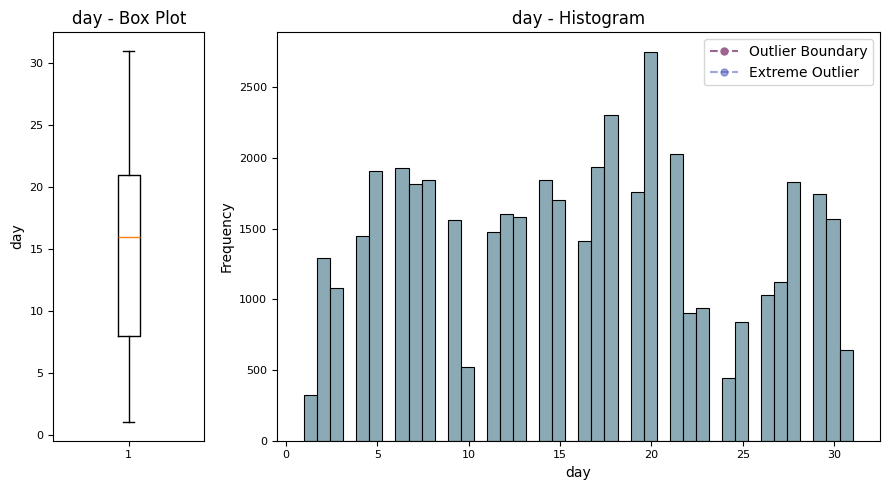

In [47]:
plot_boxplot_histogram(bank_marketing, 'day')

For `day` there are no outliers since all values range betwee integer values **1 - 31**. Next, variable `campaign` is being analyzed.

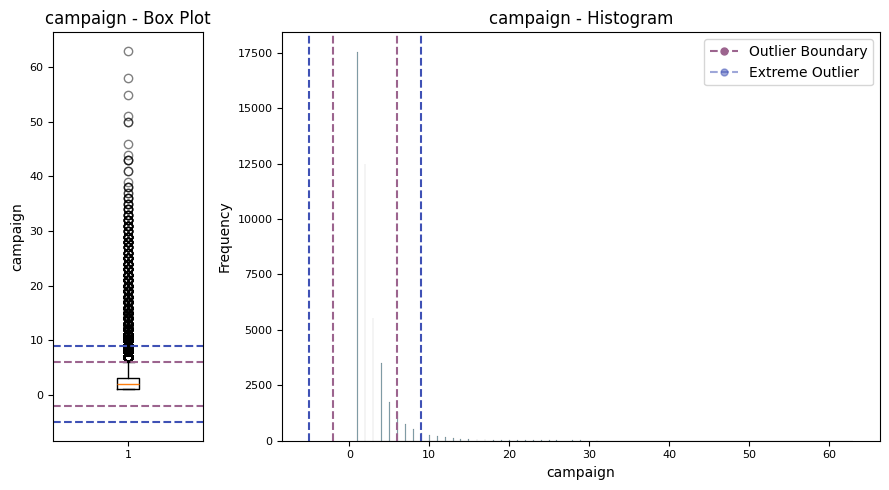

In [48]:
plot_boxplot_histogram(bank_marketing, 'campaign')

In [49]:
cmn_q1, cmn_q3, cmn_iqr, cmn_lower_bound, cmn_upper_bound, cmn_extreme_lower_bound, cmn_extreme_upper_bound, cmn_outliers, cmn_extreme_outliers = calculate_outliers(bank_marketing, 'campaign')
print_outlier_analysis('campaign', cmn_q1, cmn_q3, cmn_iqr, cmn_lower_bound, cmn_upper_bound, cmn_extreme_lower_bound, cmn_extreme_upper_bound, cmn_outliers, cmn_extreme_outliers)

campaign Outlier Analysis:
-----------------------------
First Quartile (Q1): 1.00
Third Quartile (Q3): 3.00
Interquartile Range (IQR): 2.00
Extreme Lower Bound: -5.00
Lower Bound: -2.00
Upper Bound: 6.00
Extreme Upper Bound: 9.00
Outliers Length: 3063
Extreme Outliers Length: 1461


For `campaign` we can see that there are **3063** outliers in total (starting from values of **6** for the upper bound and **-2** for the lower bound), from which **1461** are considered extreme outliers.

In [50]:
bank_marketing['campaign'].describe()

count    45208.000000
mean         2.763560
std          3.097582
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [51]:
cmn_outliers.describe()

count    3063.000000
mean       11.482207
std         6.021863
min         7.000000
25%         8.000000
50%         9.000000
75%        13.000000
max        63.000000
Name: campaign, dtype: float64

In [52]:
cmn_extreme_outliers.describe()

count    1461.000000
mean       15.579740
std         6.578189
min        10.000000
25%        11.000000
50%        13.000000
75%        18.000000
max        63.000000
Name: campaign, dtype: float64

In [53]:
bank_marketing.loc[cmn_extreme_outliers.index]

age           job   marital  education default  balance housing loan  \
2244    46   blue-collar   married    primary      no      633     yes   no   
2251    40    technician   married  secondary      no     2576     yes  yes   
2305    25        admin.    single  secondary      no        1     yes  yes   
2625    43   blue-collar   married    primary      no       17     yes   no   
2626    31    technician   married  secondary      no      106     yes   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
44100   70       retired  divorced  secondary      no     4572      no   no   
44231   32  entrepreneur   married   tertiary      no      762      no   no   
44583   24       student    single  secondary      no      431      no   no   
44594   34    technician    single   tertiary      no     2481      no   no   
44886   38    management   married   tertiary      no        0      no   no   

        contact  day month  campaign  pdays  previous    y  
2244    Unknown   12   may        10     -1         0   no  
2251    Unknown   12   may        11     -1         0   no  
2305    Unknown   12   may        12     -1         0   no  
2625    Unknown   13   may        10     -1         0   no  
2626    Unknown   13   may        13     -1         0   no  
...         ...  ...   ...       ...    ...       ...  ...  
44100  cellular    8   jul        11    162         5   no  
44231  cellular   19   jul        11     -1         0  yes  
44583  cellular   19   aug        11    185         5  yes  
44594  cellular   23   aug        16    192        14   no  
44886  cellular   24   sep        12    197         6   no  

[1461 rows x 15 columns]

By carefully, checking the statistics and some specific cases of both normal and extreme outliers of the variable `campaign`, it seems that there are several cases where the number of calls performed for the specific client during this campaing is extremely high. The extreme outliers, indicate that more than **10** calls should be discarded.

In [54]:
# Drop rows by index
bank_marketing = bank_marketing.drop(cmn_extreme_outliers.index)

# Reset index to make it sequential
bank_marketing = bank_marketing.reset_index(drop=True)

In [55]:
bank_marketing

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    Unknown      no     1506     yes   no   
4       33       Unknown    single    Unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
43742   51    technician   married   tertiary      no      825      no   no   
43743   71       retired  divorced    primary      no     1729      no   no   
43744   72       retired   married  secondary      no     5715      no   no   
43745   57   blue-collar   married  secondary      no      668      no   no   
43746   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  campaign  pdays  previous    y  
0        Unknown    5   may         1     -1         0   no  
1        Unknown    5   may         1     -1         0   no  
2        Unknown    5   may         1     -1         0   no  
3        Unknown    5   may         1     -1         0   no  
4        Unknown    5   may         1     -1         0   no  
...          ...  ...   ...       ...    ...       ...  ...  
43742   cellular   17   nov         3     -1         0  yes  
43743   cellular   17   nov         2     -1         0  yes  
43744   cellular   17   nov         5    184         3  yes  
43745  telephone   17   nov         4     -1         0   no  
43746   cellular   17   nov         2    188        11   no  

[43747 rows x 15 columns]

Next, the analysis of `pdays` is completed.

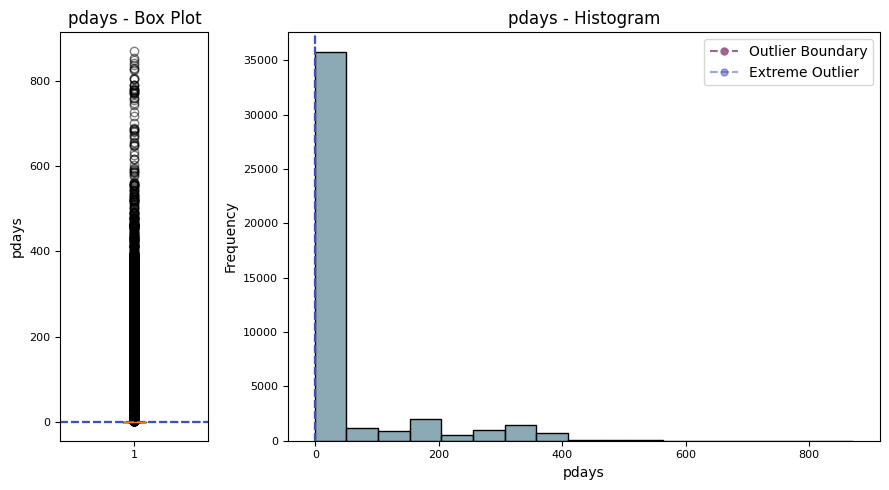

In [56]:
plot_boxplot_histogram(bank_marketing, 'pdays')

In [57]:
pdays_q1, pdays_q3, pdays_iqr, pdays_lower_bound, pdays_upper_bound, pdays_extreme_lower_bound, pdays_extreme_upper_bound, pdays_outliers, pdays_extreme_outliers = calculate_outliers(bank_marketing, 'pdays')
print_outlier_analysis('pdays', pdays_q1, pdays_q3, pdays_iqr, pdays_lower_bound, pdays_upper_bound, pdays_extreme_lower_bound, pdays_extreme_upper_bound, pdays_outliers, pdays_extreme_outliers)

pdays Outlier Analysis:
-----------------------------
First Quartile (Q1): -1.00
Third Quartile (Q3): -1.00
Interquartile Range (IQR): 0.00
Extreme Lower Bound: -1.00
Lower Bound: -1.00
Upper Bound: -1.00
Extreme Upper Bound: -1.00
Outliers Length: 8223
Extreme Outliers Length: 8223


So here for the variable `pdays` we can see that there are **8223** outliers in total (starting from values of **-1** for both the upper bound and the lower bound), from which **8223** are considered extreme outliers. Since this result does not seem reasonable, a more detailed look is required.

In [58]:
bank_marketing['pdays'].describe()

count    43747.000000
mean        41.379683
std        101.296672
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

When variable `pdays` is equal to **-1** it means that the client was never been contacted before. From the following result, we can see that this is the case for **35524** cases of the dataset.

In [59]:
bank_marketing[bank_marketing['pdays'] == -1]

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    Unknown      no     1506     yes   no   
4       33       Unknown    single    Unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
43739   23       student    single   tertiary      no      113      no   no   
43741   25    technician    single  secondary      no      505      no  yes   
43742   51    technician   married   tertiary      no      825      no   no   
43743   71       retired  divorced    primary      no     1729      no   no   
43745   57   blue-collar   married  secondary      no      668      no   no   

         contact  day month  campaign  pdays  previous    y  
0        Unknown    5   may         1     -1         0   no  
1        Unknown    5   may         1     -1         0   no  
2        Unknown    5   may         1     -1         0   no  
3        Unknown    5   may         1     -1         0   no  
4        Unknown    5   may         1     -1         0   no  
...          ...  ...   ...       ...    ...       ...  ...  
43739   cellular   17   nov         1     -1         0  yes  
43741   cellular   17   nov         2     -1         0  yes  
43742   cellular   17   nov         3     -1         0  yes  
43743   cellular   17   nov         2     -1         0  yes  
43745  telephone   17   nov         4     -1         0   no  

[35524 rows x 15 columns]

Let's see what is true for the cases, where the client had been contacted before.

In [60]:
bank_marketing[bank_marketing['pdays'] != -1].describe()['pdays']

count    8223.000000
mean      224.463213
std       115.374053
min         1.000000
25%       132.000000
50%       194.000000
75%       327.000000
max       871.000000
Name: pdays, dtype: float64

In [61]:
pdays_outliers.describe()

count    8223.000000
mean      224.463213
std       115.374053
min         1.000000
25%       132.000000
50%       194.000000
75%       327.000000
max       871.000000
Name: pdays, dtype: float64

In [62]:
pdays_extreme_outliers.describe()

count    8223.000000
mean      224.463213
std       115.374053
min         1.000000
25%       132.000000
50%       194.000000
75%       327.000000
max       871.000000
Name: pdays, dtype: float64

We can see that, the number of client's that had been contacted before is the same as the number of outliers. For that reason, leaving out the client's having a value of **-1** for this variable, we conduct once more the outliers analysis.

In [63]:
pdays_filtered = bank_marketing[bank_marketing['pdays'] != -1]['pdays']

q1 = np.percentile(pdays_filtered, 25)
q3 = np.percentile(pdays_filtered, 75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = [(pdays_filtered < lower_bound) | (pdays_filtered > upper_bound)]
extreme_outliers = [(pdays_filtered < q1 - 3 * iqr) | (pdays_filtered > q3 + 3 * iqr)]

# Calculate statistics for outliers
num_outliers = outliers[0].sum();
percentage_outliers = num_outliers / len(pdays_filtered) * 100

# Calculate statistics for extreme outliers
num_extreme_outliers = extreme_outliers[0].sum();
percentage_extreme_outliers = num_extreme_outliers / len(pdays_filtered) * 100

outlier_stats = {
    'Number of Outliers': num_outliers,
    'Percentage of Outliers': percentage_outliers,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound
}

extreme_outlier_stats = {
    'Number of Extreme Outliers': num_extreme_outliers,
    'Percentage of Extreme Outliers': percentage_extreme_outliers,
    'Q1 - 3*IQR': q1 - 3 * iqr,
    'Q3 + 3*IQR': q3 + 3 * iqr
}

print("Statistics for Outliers:")
for key, value in outlier_stats.items():
    print(f"{key}: {value}")

print("\nStatistics for Extreme Outliers:")
for key, value in extreme_outlier_stats.items():
    print(f"{key}: {value}")


Statistics for Outliers:
Number of Outliers: 49
Percentage of Outliers: 0.5958895780128907
Lower Bound: -160.5
Upper Bound: 619.5

Statistics for Extreme Outliers:
Number of Extreme Outliers: 0
Percentage of Extreme Outliers: 0.0
Q1 - 3*IQR: -453.0
Q3 + 3*IQR: 912.0


In [64]:
# Access the extreme outliers and outliers
extreme_outliers_values = pdays_filtered[extreme_outliers[0]].describe()
outliers_values = pdays_filtered[outliers[0]].describe()

# Print the extreme outliers and outliers
print("Extreme Outliers Statistics:")
print(extreme_outliers_values)

print("\nOutliers Statistics:")
print(outliers_values)

Extreme Outliers Statistics:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: pdays, dtype: float64

Outliers Statistics:
count     49.000000
mean     747.591837
std       67.299368
min      626.000000
25%      686.000000
50%      769.000000
75%      792.000000
max      871.000000
Name: pdays, dtype: float64


From the previous analysis, we do not discrard any of the clients, because they are not extreme outliers.

Finally, variable `previous` is being analysed.

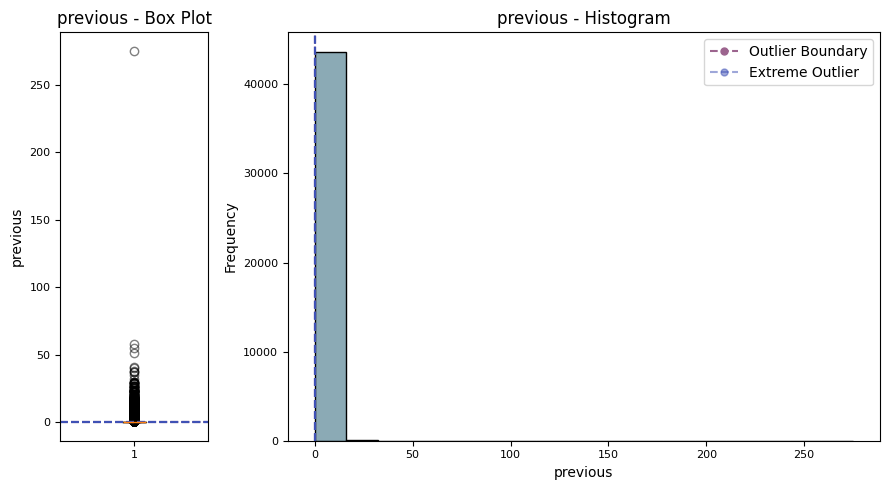

In [65]:
plot_boxplot_histogram(bank_marketing, 'previous')

In [66]:
prev_q1, prev_q3, prev_iqr, prev_lower_bound, prev_upper_bound, prev_extreme_lower_bound, prev_extreme_upper_bound, prev_outliers, prev_extreme_outliers = calculate_outliers(bank_marketing, 'previous')
print_outlier_analysis('previous', prev_q1, prev_q3, prev_iqr, prev_lower_bound, prev_upper_bound, prev_extreme_lower_bound, prev_extreme_upper_bound, prev_outliers, prev_extreme_outliers)

previous Outlier Analysis:
-----------------------------
First Quartile (Q1): 0.00
Third Quartile (Q3): 0.00
Interquartile Range (IQR): 0.00
Extreme Lower Bound: 0.00
Lower Bound: 0.00
Upper Bound: 0.00
Extreme Upper Bound: 0.00
Outliers Length: 8223
Extreme Outliers Length: 8223


In [67]:
bank_marketing[bank_marketing['previous'] != 0].describe()['previous']

count    8223.000000
mean        3.169281
std         4.546877
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       275.000000
Name: previous, dtype: float64

In [68]:
prev_outliers.describe()

count    8223.000000
mean        3.169281
std         4.546877
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       275.000000
Name: previous, dtype: float64

In [69]:
prev_extreme_outliers.describe()

count    8223.000000
mean        3.169281
std         4.546877
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       275.000000
Name: previous, dtype: float64

The same seems to be happening here for variable `previous`. For that reason the same methodology will be followed for treating the outliers.

In [70]:
previous_filtered = bank_marketing[bank_marketing['previous'] != 0]['previous']

q1 = np.percentile(previous_filtered, 25)
q3 = np.percentile(previous_filtered, 75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = [(previous_filtered < lower_bound) | (previous_filtered > upper_bound)]
extreme_outliers = [(previous_filtered < q1 - 3 * iqr) | (previous_filtered > q3 + 3 * iqr)]

# Calculate statistics for outliers
num_outliers = outliers[0].sum();
percentage_outliers = num_outliers / len(previous_filtered) * 100

# Calculate statistics for extreme outliers
num_extreme_outliers = extreme_outliers[0].sum();
percentage_extreme_outliers = num_extreme_outliers / len(previous_filtered) * 100

outlier_stats = {
    'Number of Outliers': num_outliers,
    'Percentage of Outliers': percentage_outliers,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound
}

extreme_outlier_stats = {
    'Number of Extreme Outliers': num_extreme_outliers,
    'Percentage of Extreme Outliers': percentage_extreme_outliers,
    'Q1 - 3*IQR': q1 - 3 * iqr,
    'Q3 + 3*IQR': q3 + 3 * iqr
}

print("Statistics for Outliers:")
for key, value in outlier_stats.items():
    print(f"{key}: {value}")

print("\nStatistics for Extreme Outliers:")
for key, value in extreme_outlier_stats.items():
    print(f"{key}: {value}")


Statistics for Outliers:
Number of Outliers: 447
Percentage of Outliers: 5.435972272893105
Lower Bound: -3.5
Upper Bound: 8.5

Statistics for Extreme Outliers:
Number of Extreme Outliers: 144
Percentage of Extreme Outliers: 1.7511856986501275
Q1 - 3*IQR: -8.0
Q3 + 3*IQR: 13.0


After the same analysis for varialbe `previous`, we consider discarding all the observations for client's that were contacted more than **13** times in previoius campaigns. The idea behind this decision, is to train a model which will be able to predict if a client will subscribe or not, without the need of the marketing employee calling an extreme number of times a specific client, or targeting clients that have received huge nubmer of calls in previous campaigns. For that reason, we are discarding **144** observations, leading to a final result of shape **(43621,15)**.

In [71]:
# Set the threshold value
threshold = previous_filtered[extreme_outliers[0]].describe()['min']

# # Create a boolean mask to identify rows where column 'previous' is higher than the threshold
mask = bank_marketing['previous'] > threshold

# # Filter the DataFrame to keep only the rows where the condition is True
bank_marketing = bank_marketing[~mask]
bank_marketing = bank_marketing.reset_index(drop=True)
bank_marketing.head(10)
bank_marketing.shape

age           job   marital  education default  balance housing loan  \
0   58    management   married   tertiary      no     2143     yes   no   
1   44    technician    single  secondary      no       29     yes   no   
2   33  entrepreneur   married  secondary      no        2     yes  yes   
3   47   blue-collar   married    Unknown      no     1506     yes   no   
4   33       Unknown    single    Unknown      no        1      no   no   
5   35    management   married   tertiary      no      231     yes   no   
6   28    management    single   tertiary      no      447     yes  yes   
7   42  entrepreneur  divorced   tertiary     yes        2     yes   no   
8   58       retired   married    primary      no      121     yes   no   
9   43    technician    single  secondary      no      593     yes   no   

   contact  day month  campaign  pdays  previous   y  
0  Unknown    5   may         1     -1         0  no  
1  Unknown    5   may         1     -1         0  no  
2  Unknown    5   may         1     -1         0  no  
3  Unknown    5   may         1     -1         0  no  
4  Unknown    5   may         1     -1         0  no  
5  Unknown    5   may         1     -1         0  no  
6  Unknown    5   may         1     -1         0  no  
7  Unknown    5   may         1     -1         0  no  
8  Unknown    5   may         1     -1         0  no  
9  Unknown    5   may         1     -1         0  no

(43621, 15)

## Imputation of Missing Values

- **job**: there are only 288 missing values, less than 1% of instances of the dataset. We impute randomly weighted by the proportion of each job.
- **education**: there are only 1857 missing values, less than 1% of instances of the dataset. We impute randomly weighted by the proportion of each education level.
- **contact**: we leave the new category Unknown, given that we have more than 30% of missing values that fall into it.

In [72]:
## job
bank_marketing['job'].replace('Unknown', np.nan, inplace=True)
job_proportions = bank_marketing['job'].value_counts(normalize=True)


missing_indices = bank_marketing[bank_marketing['job'].isnull()].index

bank_marketing.loc[missing_indices, 'job'] = np.random.choice(job_proportions.index, size=len(missing_indices), p=job_proportions.values)



## education
bank_marketing['education'].replace('Unknown', np.nan, inplace=True)
ed_proportions = bank_marketing['education'].value_counts(normalize=True)


missing_indices = bank_marketing[bank_marketing['education'].isnull()].index

bank_marketing.loc[missing_indices, 'education'] = np.random.choice(ed_proportions.index, size=len(missing_indices), p=ed_proportions.values)


In [73]:
print_categorical_variables(bank_marketing)
bank_marketing['job'].unique()

Categorical Variables:
job: management, technician, entrepreneur, blue-collar, retired, admin., services, self-employed, unemployed, housemaid, student
marital: married, single, divorced
education: tertiary, secondary, primary
default: no, yes
housing: yes, no
loan: no, yes
contact: Unknown, cellular, telephone
month: may, jun, jul, aug, oct, nov, dec, jan, feb, mar, apr, sep
y: no, yes


array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'retired', 'admin.', 'services', 'self-employed', 'unemployed',
       'housemaid', 'student'], dtype=object)

In [74]:
bank_marketing

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married  secondary      no     1506     yes   no   
4       33   blue-collar    single   tertiary      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
43616   51    technician   married   tertiary      no      825      no   no   
43617   71       retired  divorced    primary      no     1729      no   no   
43618   72       retired   married  secondary      no     5715      no   no   
43619   57   blue-collar   married  secondary      no      668      no   no   
43620   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  campaign  pdays  previous    y  
0        Unknown    5   may         1     -1         0   no  
1        Unknown    5   may         1     -1         0   no  
2        Unknown    5   may         1     -1         0   no  
3        Unknown    5   may         1     -1         0   no  
4        Unknown    5   may         1     -1         0   no  
...          ...  ...   ...       ...    ...       ...  ...  
43616   cellular   17   nov         3     -1         0  yes  
43617   cellular   17   nov         2     -1         0  yes  
43618   cellular   17   nov         5    184         3  yes  
43619  telephone   17   nov         4     -1         0   no  
43620   cellular   17   nov         2    188        11   no  

[43621 rows x 15 columns]

Following, the `Bivariate Exploratory Analysis` is taking place. Part of the `Bivariate Exploratory Analysis` is the section `Multivariate Outliers Analysis` which is performed with Mahalanobis distance.

***
# SECTION 4: Bivariate Exploratory Analysis

In this section, a deeper look is taken into the relationship between the pairs of available variables with respect to the target variable `y`.

Firstly, the relation between the numerical variables with respect to the target variable is depicted in the following figure.

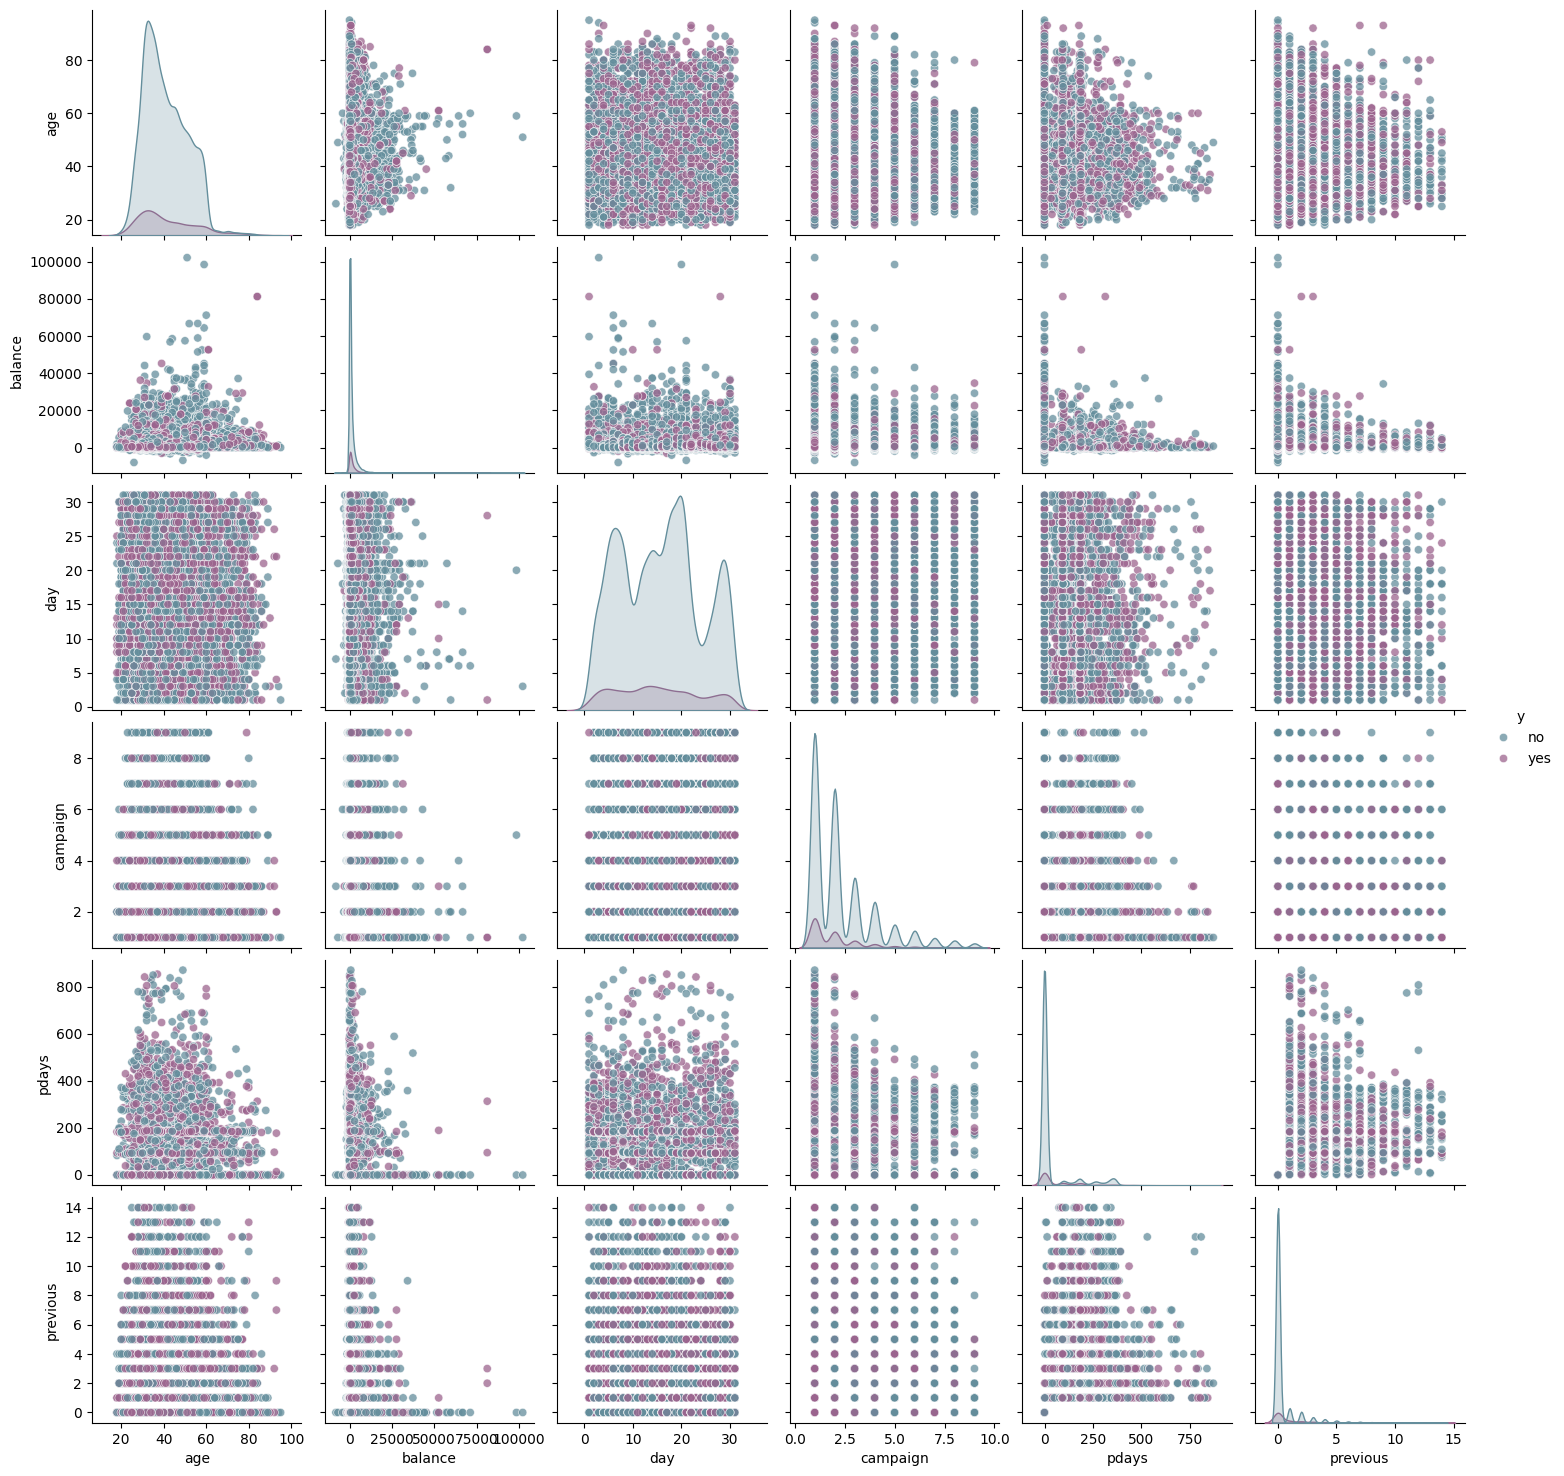

In [75]:
bivariate_numerical_exploratory_analysis(bank_marketing, 'y')

In [76]:
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43621 entries, 0 to 43620
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        43621 non-null  int64 
 1   job        43621 non-null  object
 2   marital    43621 non-null  object
 3   education  43621 non-null  object
 4   default    43621 non-null  object
 5   balance    43621 non-null  int64 
 6   housing    43621 non-null  object
 7   loan       43621 non-null  object
 8   contact    43621 non-null  object
 9   day        43621 non-null  int64 
 10  month      43621 non-null  object
 11  campaign   43621 non-null  int64 
 12  pdays      43621 non-null  int64 
 13  previous   43621 non-null  int64 
 14  y          43621 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.0+ MB


Before stating the conclusions of the generated figure, let's take a look at the *Correlation Heatmap* below as well.

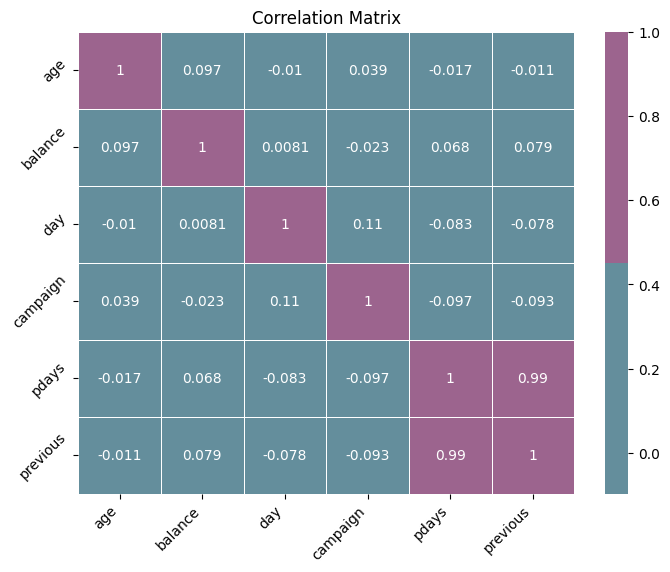

age   balance       day  campaign     pdays  previous
age       1.000000  0.096683 -0.010151  0.039352 -0.016744 -0.010834
balance   0.096683  1.000000  0.008137 -0.023226  0.068426  0.078611
day      -0.010151  0.008137  1.000000  0.108936 -0.082771 -0.078201
campaign  0.039352 -0.023226  0.108936  1.000000 -0.097046 -0.093480
pdays    -0.016744  0.068426 -0.082771 -0.097046  1.000000  0.985063
previous -0.010834  0.078611 -0.078201 -0.093480  0.985063  1.000000

In [77]:
correlation_heatmap(bank_marketing)

We can observe a clear correlation between `pdays` and `previous`, which was expected due to the fact both variables represent information about past contacts with the potential client, one giving the number of days that passed by after the client was last contacted from a previous campaign and the other measures number of contacts performed before this campaign and for this client. For that reason, it was decided to drop variable `pdays`.

In [78]:
# Drop a column, for example, column 'B'
bank_marketing = bank_marketing.drop('pdays', axis=1)

On the other hand, we do not see any significant correlations between any other pair of numerical variables.

To continue with, in the next plot, the distribution of the categorical variables with respect to the target varible is presented.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


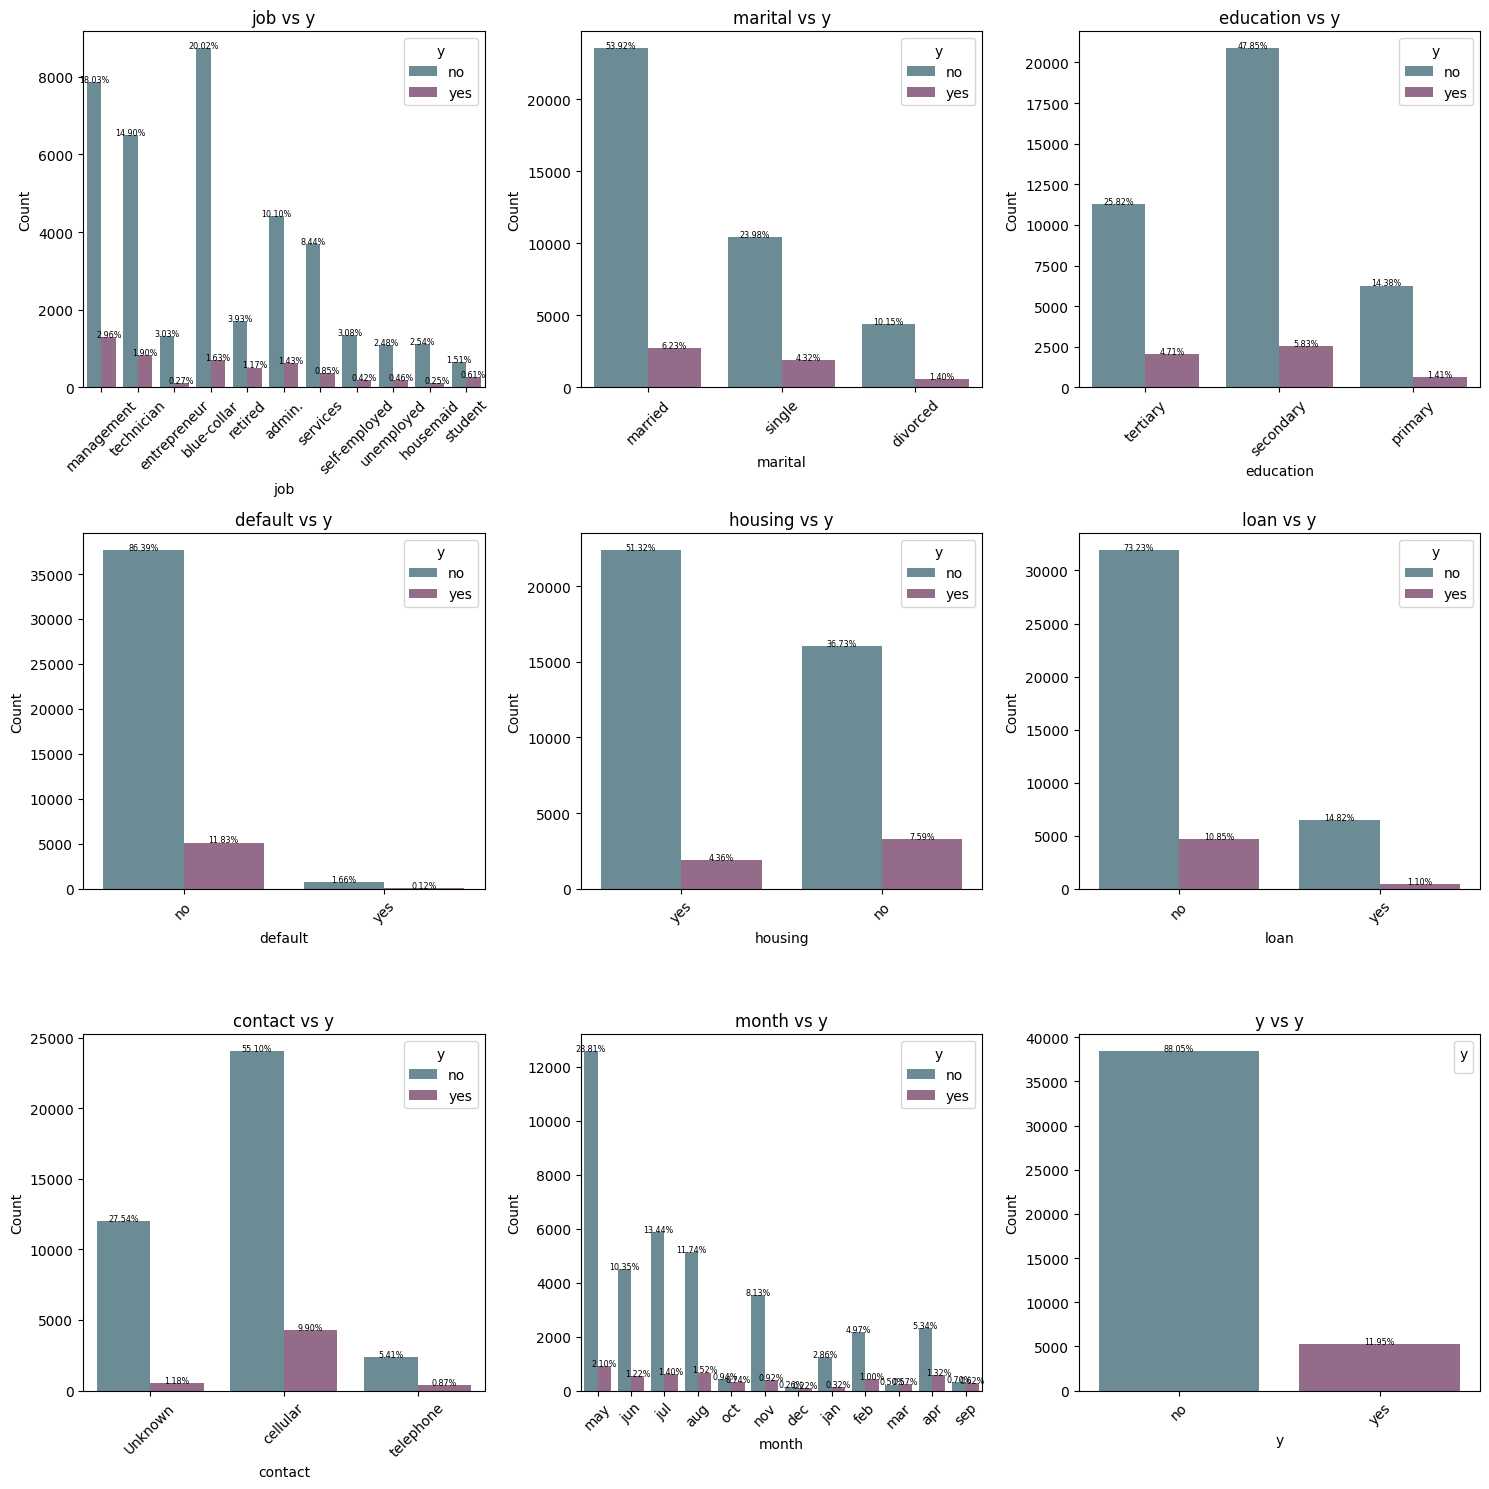

In [79]:
plot_categorical_variables(bank_marketing, "y")

Before concluding about the categorical variables, it is necessary to **statistically test** if correlation exist between them by using the `Chi-Squared` test.

In [80]:
chi_squared_results = perform_chi_squared_test(bank_marketing, cat_cols)
print(chi_squared_results)
chi_squared_results.to_csv("./chi-2.csv")

   Variable 1 Variable 2    Chi-square        P-value
0         job    marital   3690.940488   0.000000e+00
1         job  education  24563.688761   0.000000e+00
2         job    default     56.983548   1.342448e-08
3         job    housing   3254.037003   0.000000e+00
4         job       loan    437.388332   1.021992e-87
..        ...        ...           ...            ...
67          y    default     19.998433   7.750566e-06
68          y    housing    886.521489  8.354329e-195
69          y       loan    200.939041   1.302910e-45
70          y    contact   1030.884485  1.400485e-224
71          y      month   2997.778113   0.000000e+00

[72 rows x 4 columns]


By considering the barplots above, there is not clear conclusions to be made, due to the unbalanced nature of the dataset as mentioned earlier. However, some interesting insights generated by this figure can be conducted for the variables `job`, `marital`, `education`, `housing`, `loan`, `contact` and `month`. More precisely:

1. **Job**: it can be seen that `retired` people and `students` have a huge difference compared to other groups, on accepting the subscription. Also people with jobs: `management` and `enterpeuners` tend to decline the offer more than the other groups.
2. **Marital**: `single` people are more likely to accept the marketig offer, compared to `married` ones.
3. **Education**: as education level gets higher, the ration of accepting the offer over rejecting it gets higher, with a great difference for the `tertiary` category.
4. **Housing**: people without a housing loan are more likely to accept the marketing offer.
5. **Loan**: same is true for personal loan.
6. **Contact**: people being contacted via `celular` tend to accept the offer more than the ones contacted with `telephone`.
7. **Month**: `sep`, `dec` and `feb` months present one of the highest ratios of accepting over rejecting the marketing offer.

In addition, by taking a look at the produced `csv` file, the following conclusions can be derived:
1. **Job and Marital Status**: Strong association (Chi-square = 3690.60, p < 0.001).
2. **Job and Education**: Strong association (Chi-square = 24539.68, p < 0.001).
3. **Job and Loan**: Strong association (Chi-square = 435.98, p < 0.001).
4. **Marital Status and Education**: Strong association (Chi-square = 1227.27, p < 0.001).
5. **Marital Status and Loan**: Strong association (Chi-square = 121.18, p < 0.001).
6. **Education and Month**: Strong association (Chi-square = 1408.88, p < 0.001).
7. **Default and Loan**: Strong association (Chi-square = 252.48, p < 0.001).
8. **Housing and Month**: Strong association (Chi-square = 11147.09, p < 0.001).
9. **Loan and Month**: Strong association (Chi-square = 1429.45, p < 0.001).
10. **Contact and Month**: Strong association (Chi-square = 22464.80, p < 0.001).
11. **Month and Y (Outcome)**: Strong association (Chi-square = 2997.78, p < 0.001).

## Multivariate Outliers Analysis

In addition, though, we'll perform a multivariate outlier detection using `Mahalanobis Distance` of the numerical variables of the dataset. In order to do so the calculation of the covariance matrix and its inverse is necessary in order to calculate the distances between the observations of the dataset.

In [81]:
#MULTIVARIATE OUTLIERS ANALYSIS WITH ROBUST MAHALANOBIS AND MAHALANOBIS
from sklearn.covariance import MinCovDet
# Robust covariance matrix
df_numeric = bank_marketing.select_dtypes(include=np.number)
robust_cov = MinCovDet().fit(df_numeric)

# Calculate the Mahalanobis distance
mahal_dist = robust_cov.mahalanobis(df_numeric)

# Set the threshold for identifying outliers
quantile = 0.99
cutoff = np.quantile(mahal_dist, quantile)

# Identify multivariate outliers
mult_outliers = np.where(mahal_dist > cutoff)[0]

# Get the top 10 most extreme outliers
extreme_outliers_idx = np.argsort(mahal_dist)[-10:]

# Plot MD vs RMD
plt.figure(figsize=(10, 8))

# Scatter plot for all data points
plt.scatter(mahal_dist, mahal_dist, alpha=0.6, color='#648E9C', label='Data Points')

# Scatter plot for the extreme outliers
plt.scatter(mahal_dist[extreme_outliers_idx], mahal_dist[extreme_outliers_idx], color='#E8F1F4', s=100, label='Top 10 Outliers')

# Annotate multivariate outliers on the plot
for i in extreme_outliers_idx:
    plt.annotate(bank_marketing.index[i], (mahal_dist[i], mahal_dist[i]),
                 textcoords="offset points", xytext=(0, 5), ha='left', fontsize=8, color='#9CB1BC')

# Highlight the threshold
plt.axhline(y=cutoff, color='#C5D4DE', linestyle='--', label='Threshold')
plt.axvline(x=cutoff, color='#C5D4DE', linestyle='--')

# Title and labels
plt.title("Multivariate Outliers", fontsize=14)
plt.xlabel("Mahalanobis Distance", fontsize=12)
plt.ylabel("Robust Mahalanobis Distance", fontsize=12)

# Legend
plt.legend();

# Show the plot
plt.show();

In [82]:
print(len(mult_outliers))
print(len(extreme_outliers_idx))

437
10


In [84]:
bank_marketing.iloc[extreme_outliers_idx]
#bank_marketing_cleaned = bank_marketing.drop(index=bank_marketing.index[extreme_outliers_idx])

age           job   marital  education default  balance housing loan  \
12434   56   blue-collar   married  secondary      no    58932      no   no   
39823   32  entrepreneur    single   tertiary      no    59649      no   no   
18519   59        admin.   married  secondary      no    64343      no   no   
20265   52   blue-collar   married    primary      no    66653      no   no   
18882   56    management  divorced   tertiary      no    66721      no   no   
40141   60       retired   married    primary      no    71188      no   no   
40997   84       retired   married  secondary      no    81204      no   no   
41826   84       retired   married  secondary      no    81204      no   no   
24871   59    management   married   tertiary      no    98417      no   no   
38444   51    management    single   tertiary      no   102127      no   no   

         contact  day month  campaign  previous    y  
12434  telephone    7   jul         2         0   no  
39823   cellular    1   sep         2         0   no  
18519   cellular    6   aug         4         0   no  
20265   cellular   14   aug         3         0   no  
18882   cellular    8   aug         2         0   no  
40141   cellular    6   oct         1         0   no  
40997  telephone   28   dec         1         2  yes  
41826  telephone    1   apr         1         3  yes  
24871  telephone   20   nov         5         0   no  
38444   cellular    3   jun         1         0   no

As the above figure presents, based on the Mahalanobis distance, there are **437** multivariate outliers, where the top **10** seem to be very different than the rest of the data. After carefull consideration, by taking a look at those observations, we consider deleting them from the analysis, leading to a new shape of the dataset being **(43611, 14)**. Although, we might return to this point in case of failures during the modelling phase.

In [85]:
# Drop extreme outliers from the original DataFrame in place
bank_marketing.drop(index=extreme_outliers_idx, inplace=True)

In [87]:
bank_marketing.shape

(43611, 14)

***
# SECTION 5: Description of Mixed Data



With the following command it is clear that all categorical variables are set to be of type `object`.

In [88]:
bank_marketing.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
campaign      int64
previous      int64
y            object
dtype: object

In [89]:
print_numerical_variables(bank_marketing)

Numerical Variables:
age
balance
day
campaign
previous


In [90]:
print_categorical_variables(bank_marketing)

Categorical Variables:
job: management, technician, entrepreneur, blue-collar, retired, admin., services, self-employed, unemployed, housemaid, student
marital: married, single, divorced
education: tertiary, secondary, primary
default: no, yes
housing: yes, no
loan: no, yes
contact: Unknown, cellular, telephone
month: may, jun, jul, aug, oct, nov, dec, jan, feb, mar, apr, sep
y: no, yes


In [91]:
import warnings
# Get the summary of categorical data
summary = pd.DataFrame(columns=['Variable', 'Value', 'Count'])

# Iterate over each column
for column in bank_marketing.columns:
    # Check if the column is categorical
    if bank_marketing[column].dtype in ['object', 'category']:
        # Calculate the value counts
        value_counts = bank_marketing[column].value_counts().reset_index()
        value_counts.columns = ['Value', 'Count']

        # Add the variable name to the summary
        value_counts['Variable'] = column

        # Append to the summary DataFrame
        summary = pd.concat([summary, value_counts], ignore_index=True)

# Print the summary
print(summary)

     Variable          Value  Count
0         job    blue-collar   9440
1         job     management   9151
2         job     technician   7330
3         job         admin.   5027
4         job       services   4052
5         job        retired   2224
6         job  self-employed   1527
7         job   entrepreneur   1438
8         job     unemployed   1283
9         job      housemaid   1215
10        job        student    924
11    marital        married  26230
12    marital         single  12343
13    marital       divorced   5038
14  education      secondary  23410
15  education       tertiary  13314
16  education        primary   6887
17    default             no  42837
18    default            yes    774
19    housing            yes  24288
20    housing             no  19323
21       loan             no  36667
22       loan            yes   6944
23    contact       cellular  28344
24    contact        Unknown  12528
25    contact      telephone   2739
26      month            may

***
# SECTION 6: Feature Extraction

- **Education**: To simplify our feature space and facilitate SVM fitting without losing information, we have decided to transform the `education` variable from a categorical variable to a numerical ordinal one. The mapping is as follows: primary=1, secondary=2, and tertiary=3.

- **Job**: Due to imbalancing and the excessive number of categories, we have created a shortened and balanced version of the `job` variable. Two different tries are implemented. The first try refers to the creation of the categories: *business* and *others*, due to the imbalanced nature of the data. The *business* category includes jobs related to business, while *others* encompasses all jobs not related to business, along with unemployed clients. However, since in `Bivariate analysis` some minor patterns were revealed indicating that professions `student` and `retired` significantly affect the marketing result, the following idea was tried as well. The second try includes the following categories: `business` from initial values of `admin`, `entrepreneur`, and `management`, and `student` and `retired`.

- **Marital**: Initially, we considered reducing the number of categories in the `marital` variable to 2, *married* and *not married*. However, we discarded this idea due to different and likely significant bivariate relations between *single*, *divorced*, and the target variable.

- **Month**: The `month` variable poses a challenge with its numerous modalities. Despite the imbalance, with the majority of marketing occurring in "May," we have chosen to leave this variable as is.


In [92]:
## education
education_mapping = {'primary': 1, 'secondary': 2, 'tertiary': 3}
bank_marketing['education'] = bank_marketing['education'].map(education_mapping)

## job
job_mapping = {'admin.': 'business', 'entrepreneur': 'business', 'management': 'business'}
bank_marketing['job_1'] = bank_marketing['job'].map(job_mapping).fillna('others')

# Define the mapping for the new feature
new_job_mapping = {'admin.': 'business', 'entrepreneur': 'business', 'management': 'business', 'student': 'student', 'retired': 'retired'}

# Create the new feature based on the mapping
bank_marketing['job_2'] = bank_marketing['job'].map(new_job_mapping).fillna('others')


In [93]:
bank_marketing

age           job   marital  education default  balance housing loan  \
0       58    management   married          3      no     2143     yes   no   
1       44    technician    single          2      no       29     yes   no   
2       33  entrepreneur   married          2      no        2     yes  yes   
3       47   blue-collar   married          2      no     1506     yes   no   
4       33   blue-collar    single          3      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
43616   51    technician   married          3      no      825      no   no   
43617   71       retired  divorced          1      no     1729      no   no   
43618   72       retired   married          2      no     5715      no   no   
43619   57   blue-collar   married          2      no      668      no   no   
43620   37  entrepreneur   married          2      no     2971      no   no   

         contact  day month  campaign  previous    y     job_1     job_2  
0        Unknown    5   may         1         0   no  business  business  
1        Unknown    5   may         1         0   no    others    others  
2        Unknown    5   may         1         0   no  business  business  
3        Unknown    5   may         1         0   no    others    others  
4        Unknown    5   may         1         0   no    others    others  
...          ...  ...   ...       ...       ...  ...       ...       ...  
43616   cellular   17   nov         3         0  yes    others    others  
43617   cellular   17   nov         2         0  yes    others   retired  
43618   cellular   17   nov         5         3  yes    others   retired  
43619  telephone   17   nov         4         0   no    others    others  
43620   cellular   17   nov         2        11   no  business  business  

[43611 rows x 16 columns]

After the manipulation of the mentioned columns, it is decided to drop the old `job` feature and rename the new columns.

In [94]:
# Drop the 'job' column
bank_marketing.drop('job', axis=1, inplace=True)

# Rename 'job_1' to 'job' and 'job_2' to 'job2'
bank_marketing.rename(columns={'job_1': 'job', 'job_2': 'job2'}, inplace=True)


In [95]:
bank_marketing

age   marital  education default  balance housing loan    contact  day  \
0       58   married          3      no     2143     yes   no    Unknown    5   
1       44    single          2      no       29     yes   no    Unknown    5   
2       33   married          2      no        2     yes  yes    Unknown    5   
3       47   married          2      no     1506     yes   no    Unknown    5   
4       33    single          3      no        1      no   no    Unknown    5   
...    ...       ...        ...     ...      ...     ...  ...        ...  ...   
43616   51   married          3      no      825      no   no   cellular   17   
43617   71  divorced          1      no     1729      no   no   cellular   17   
43618   72   married          2      no     5715      no   no   cellular   17   
43619   57   married          2      no      668      no   no  telephone   17   
43620   37   married          2      no     2971      no   no   cellular   17   

      month  campaign  previous    y       job      job2  
0       may         1         0   no  business  business  
1       may         1         0   no    others    others  
2       may         1         0   no  business  business  
3       may         1         0   no    others    others  
4       may         1         0   no    others    others  
...     ...       ...       ...  ...       ...       ...  
43616   nov         3         0  yes    others    others  
43617   nov         2         0  yes    others   retired  
43618   nov         5         3  yes    others   retired  
43619   nov         4         0   no    others    others  
43620   nov         2        11   no  business  business  

[43611 rows x 15 columns]

Before moving to the final description of the new version of the dataset, we include the transformations of the variables based on the analysis of `Univariate Analysis`. Specifically, the logarithm of the positive values for the variables `campaign` and `previous` are applied (`pdays` were discarded). However, for the variable `balance`, it was finally decided to leave it as it is, because the transformation of the negative values need to be taken into serious consideration. For that reason, we retained the initial version. 

In [101]:
# Apply logarithm to positive values of 'campaign'
bank_marketing['log_campaign'] = np.log1p(bank_marketing['campaign'].replace(0, np.nan))

# Fill NaN values with 0 for the original 'campaign' values that were 0
bank_marketing['log_campaign'].fillna(0, inplace=True)

In [102]:
# Apply logarithm to positive values of 'campaign'
bank_marketing['log_previous'] = np.log1p(bank_marketing['previous'].replace(0, np.nan))

# Fill NaN values with 0 for the original 'campaign' values that were 0
bank_marketing['log_previous'].fillna(0, inplace=True)

In [103]:
bank_marketing

age   marital  education default  balance housing loan    contact  day  \
0       58   married          3      no     2143     yes   no    Unknown    5   
1       44    single          2      no       29     yes   no    Unknown    5   
2       33   married          2      no        2     yes  yes    Unknown    5   
3       47   married          2      no     1506     yes   no    Unknown    5   
4       33    single          3      no        1      no   no    Unknown    5   
...    ...       ...        ...     ...      ...     ...  ...        ...  ...   
43616   51   married          3      no      825      no   no   cellular   17   
43617   71  divorced          1      no     1729      no   no   cellular   17   
43618   72   married          2      no     5715      no   no   cellular   17   
43619   57   married          2      no      668      no   no  telephone   17   
43620   37   married          2      no     2971      no   no   cellular   17   

      month  campaign  previous    y       job      job2  log_campaign  \
0       may         1         0   no  business  business      0.693147   
1       may         1         0   no    others    others      0.693147   
2       may         1         0   no  business  business      0.693147   
3       may         1         0   no    others    others      0.693147   
4       may         1         0   no    others    others      0.693147   
...     ...       ...       ...  ...       ...       ...           ...   
43616   nov         3         0  yes    others    others      1.386294   
43617   nov         2         0  yes    others   retired      1.098612   
43618   nov         5         3  yes    others   retired      1.791759   
43619   nov         4         0   no    others    others      1.609438   
43620   nov         2        11   no  business  business      1.098612   

       log_previous  
0          0.000000  
1          0.000000  
2          0.000000  
3          0.000000  
4          0.000000  
...             ...  
43616      0.000000  
43617      0.000000  
43618      1.386294  
43619      0.000000  
43620      2.484907  

[43611 rows x 17 columns]

Next the description of the final dataset is taking place.

## Description of Final Dataset

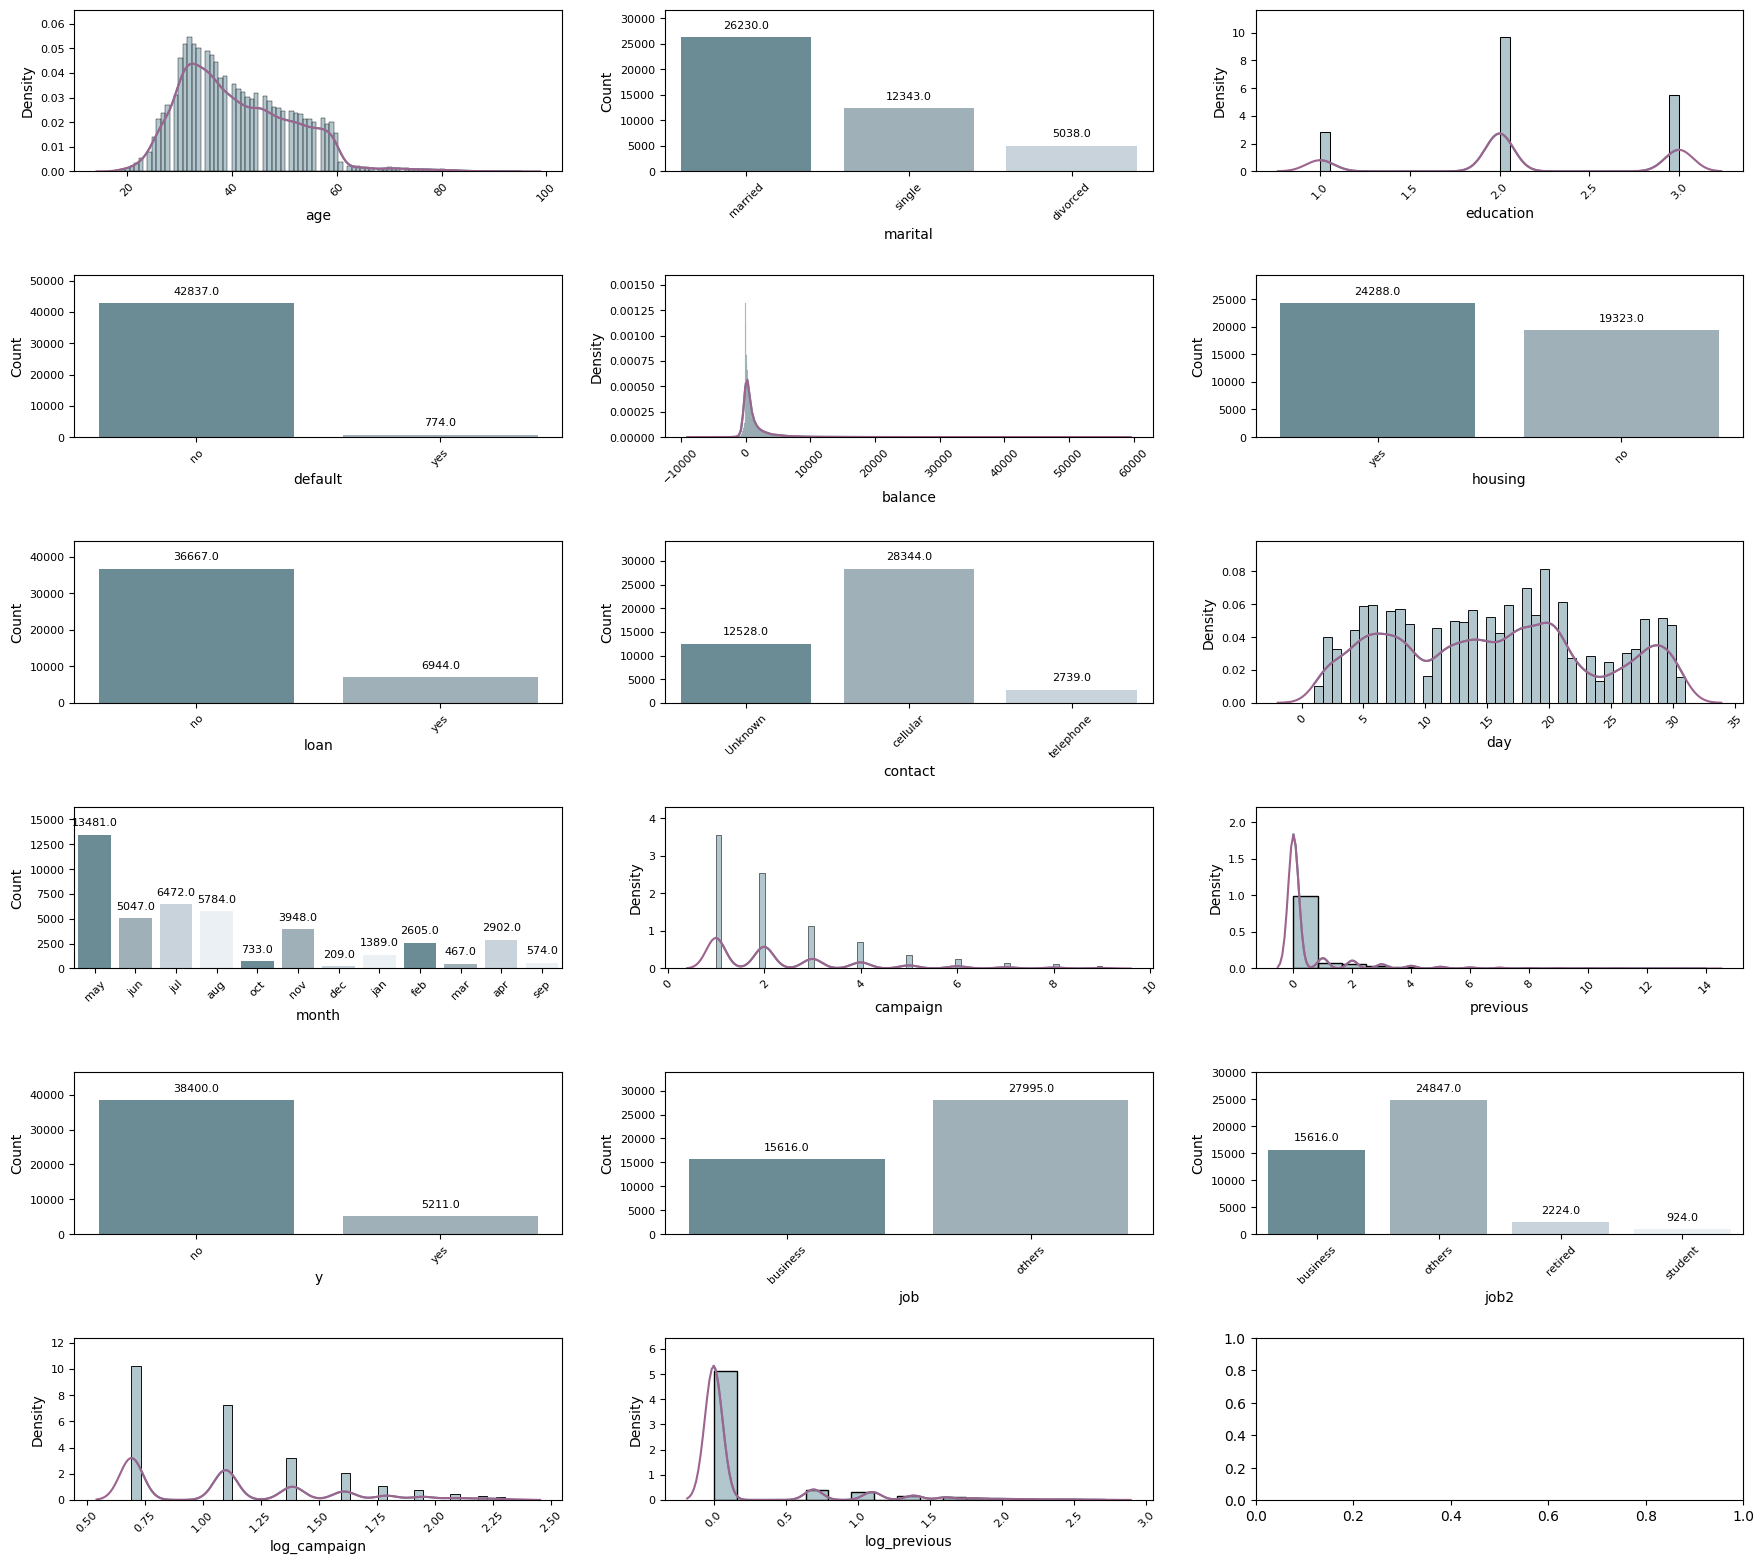

In [106]:
plot_dataframe(bank_marketing,6,3)

In [107]:
bivariate_numerical_exploratory_analysis(bank_marketing, 'y')

In [108]:
plot_categorical_variables(bank_marketing, "y")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


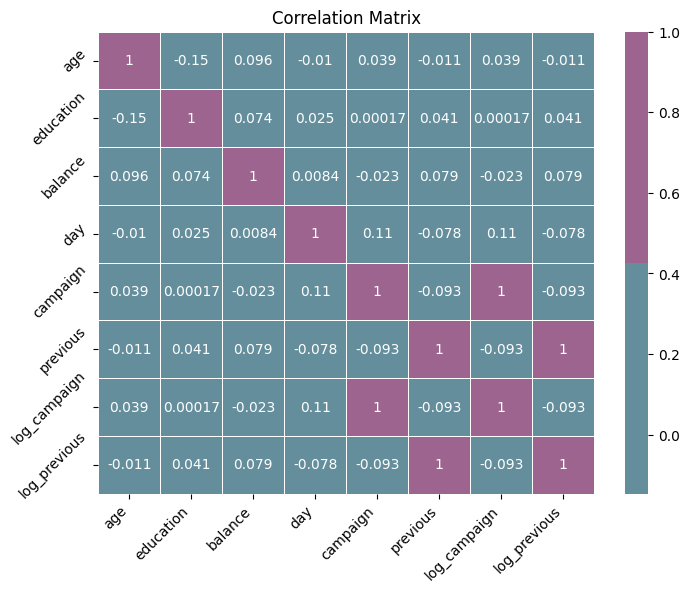

age  education   balance       day  campaign  previous  \
age           1.000000  -0.146589  0.096249 -0.010011  0.039393 -0.010919   
education    -0.146589   1.000000  0.074084  0.025182  0.000169  0.040713   
balance       0.096249   0.074084  1.000000  0.008440 -0.023230  0.078628   
day          -0.010011   0.025182  0.008440  1.000000  0.108920 -0.078279   
campaign      0.039393   0.000169 -0.023230  0.108920  1.000000 -0.093374   
previous     -0.010919   0.040713  0.078628 -0.078279 -0.093374  1.000000   
log_campaign  0.039393   0.000169 -0.023230  0.108920  1.000000 -0.093374   
log_previous -0.010919   0.040713  0.078628 -0.078279 -0.093374  1.000000   

              log_campaign  log_previous  
age               0.039393     -0.010919  
education         0.000169      0.040713  
balance          -0.023230      0.078628  
day               0.108920     -0.078279  
campaign          1.000000     -0.093374  
previous         -0.093374      1.000000  
log_campaign      1.000000     -0.093374  
log_previous     -0.093374      1.000000

In [109]:
correlation_heatmap(bank_marketing)

By following the same logic described during the `Univariate` and `Bivariate` analysis, conclusions can be derived for the new generated features. Also the retaining both `previous`, `log_previous` and `campaign`, `log_campaign` is being done intentionaly. The performance of the model will be tested by using the variables in their different formats.

***
# SECTION 7: Saving the Dataset

To prevent an oredered learning from our model, we will shuffle the data. Also, as we do not have a huge dataset and compression is not necessary, we will save the new data into a csv file.

## Important Note
It's important to note here that, the preprocessing (applying BoxCox transformation to numerical variables, or `One-hot encoding` to categorical variables) as well as the normalization of the data with the a `Scaler` is taking place in the modelling notebooks, in order to be able to apply the transformations and the normalisation techniques on the training and test datasets separately.

In [110]:
np.random.seed(666)
bank_marketing_new = bank_marketing.sample(frac=1).reset_index(drop=True)

In [111]:
bank_marketing_new.to_csv('bank_marketing_new.csv', index=False)

In [112]:
bank_marketing_read = read_csv("bank_marketing_new.csv", header=0, delimiter=',')

In [117]:
bank_marketing_read.tail(10)

age  marital  education default  balance housing loan   contact  day  \
43601   28  married          2      no     1595      no   no  cellular    9   
43602   58  married          2      no     9994      no   no  cellular   10   
43603   32  married          2      no      659      no  yes  cellular   28   
43604   39   single          3      no      741     yes   no  cellular    7   
43605   43   single          1      no      193     yes   no   Unknown    8   
43606   37  married          2      no      209      no   no  cellular   14   
43607   70  married          1      no     2795      no   no  cellular    8   
43608   25   single          3      no      777     yes   no   Unknown   14   
43609   64  married          3      no     4688      no   no  cellular   21   
43610   52  married          1      no      310      no  yes   Unknown   12   

      month  campaign  previous    y       job      job2  log_campaign  \
43601   sep         1         4  yes  business  business      0.693147   
43602   jul         1         0   no    others    others      0.693147   
43603   jul         2         0   no    others    others      1.098612   
43604   may         1         0   no    others    others      0.693147   
43605   may         7         0   no    others    others      2.079442   
43606   oct         3         7   no  business  business      1.386294   
43607   jan         2         0  yes    others   retired      1.098612   
43608   may         1         0   no    others    others      0.693147   
43609   oct         1         0  yes  business  business      0.693147   
43610   jun         4         0   no    others    others      1.609438   

       log_previous  
43601      1.609438  
43602      0.000000  
43603      0.000000  
43604      0.000000  
43605      0.000000  
43606      2.079442  
43607      0.000000  
43608      0.000000  
43609      0.000000  
43610      0.000000

In [119]:
bank_marketing_read.shape

(43611, 17)

The final dataset has a shape of **(43611, 17)**, however **2** variables are repeated twice, leading to a final dataset of shape **(43611, 15)**.